<a href="https://colab.research.google.com/github/parsaroozbahani/travel-system/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
📤 ویدیو را انتخاب کن…


Saving train.mp4 to train.mp4
0


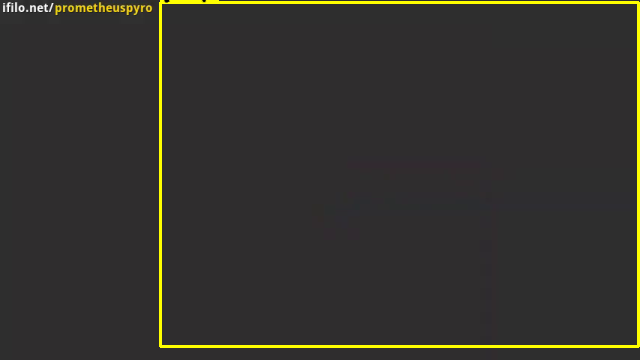

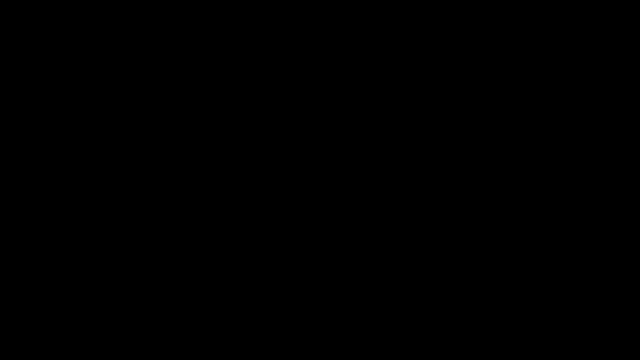

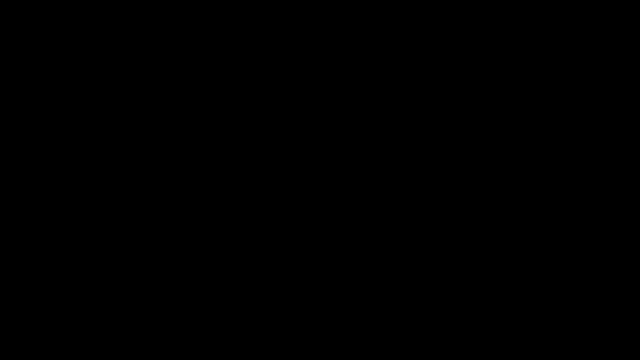

📁 خروجی‌ها در: /content/out_clean


In [1]:
# =====================[ Metro Front OCR — YOLO + Right-Lamp Lock + Fast OCR | Clean Debug ]=====================
# خروجی: عدد 1..4 رقمی مثل 7 / 362 / 0001. اگر پیدا نشد: 0
# توقف: پس از خواندن عدد یا خروج دماغه از کادر

# 0) Deps (Colab/Ubuntu)
!apt-get -yqq install tesseract-ocr tesseract-ocr-eng tesseract-ocr-fas >/dev/null
!pip -q install ultralytics opencv-python-headless pytesseract >/dev/null

# 1) Imports
import os, re, sys, cv2, numpy as np, pytesseract, time, collections
from ultralytics import YOLO
from pytesseract import Output

# ---- Colab-safe viewer ----
try:
    from google.colab import files
    from google.colab.patches import cv2_imshow
    def show(img): cv2_imshow(img)
except:
    def show(img): pass

cv2.setUseOptimized(True)
try: cv2.setNumThreads(max(1, os.cpu_count()-1))
except: pass

# -------------------- CONFIG --------------------
ASK_UPLOAD          = True               # اگر در Colab هستی و می‌خواهی فایل آپلود کنی
VIDEO_PATH          = "train.mp4"        # در غیر اینصورت از این مسیر می‌خوانَد
W, H                = 640, 360           # رزولوشن کاری (CPU-friendly)

# YOLO
YOLO_WEIGHTS        = "yolov8n.pt"
YOLO_IMGSZ          = 512
YOLO_CONF           = 0.18               # اگر دور است 0.12 هم جواب می‌دهد
ACCEPTED_CLS        = {"train"}

# Cadence
YOLO_IDLE_EVERY     = 5                  # وقتی حرکتی نیست
YOLO_ACTIVE_EVERY   = 1                  # وقتی دروازهٔ حرکت داغ است
MOTION_RIGHT_X      = 0.55               # نیمهٔ راست را مانیتور کن
MOTION_AREA_MIN     = 0.004              # حداقل درصد پیکسل‌های متحرک
MOTION_GROWTH_MIN   = 0.002              # رشد نسبت به چند فریم قبل
MOTION_STREAK       = 3                  # چند فریم پشت‌سرهم

# قفل دماغه (روی باکس YOLO)
LOCK_CONSEC         = 3                  # چند فریم متوالی شرایط برقرار باشد
LOCK_RIGHT_EDGE_MIN = 0.96               # x2/W باید از این بیشتر باشد
LOCK_MIN_W_FRAC     = 0.22               # (x2-x1)/W حداقل
LOCK_LEFT_EDGE_MIN  = 0.35               # x1/W از وسط گذشته باشد
STOP_EDGE_CX        = 0.995              # چراغ راست به لبه برسد → توقف
STOP_STREAK         = 3

# چراغ راست داخل front
FR_RIGHT_F          = 0.58
FR_LOW_Y_F          = 0.58
FR_HIGH_Y_F         = 0.96
FR_AREA_MIN_F       = 0.0006
FR_AREA_MAX_F       = 0.0300
FR_AR_MIN, FR_AR_MAX= 0.55, 1.55
FR_EXT_MIN          = 0.45
BRIGHT_MIN, BR_ADD  = 120, 6
FR_X_MIN_NORM       = 0.72               # چراغ باید نسبتاً راست باشد

# ROI زیر چراغ (ضرایب نسبت به شعاع)
ROI_XOFF_K          = 1.15
ROI_YOFF_K          = 1.55
ROI_W_K             = 5.8
ROI_H_K             = 2.0

# OCR
TESS_LANGS          = "eng+fas"
TESS_WHITELIST      = "0123456789۰۱۲۳۴۵۶۷۸۹"
TESS_OEM            = 1
OCR_MIN_CONF        = 13
MAX_DIG             = 4
FORCE_ZFILL         = False              # اگر همیشه 4 رقم می‌خواهی: True
STABLE_REPEATS      = 2                  # دو بار یکسان بخوانَد کافی است

# خروجی‌ها
OUT_DIR = "/content/out_clean" if os.path.exists("/content") else "./out_clean"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------- Utils --------------------
xfarsi = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")
def only_digits(s): return re.sub(r'[^0-9]','',(s or "").translate(xfarsi))
def clamp_digits(d):
    d = only_digits(d)
    if not d: return None
    d = d[:MAX_DIG]
    return d.zfill(4) if FORCE_ZFILL else d

def draw_box(img, box, color=(0,255,0), text=None):
    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    if text:
        tw = 10+8*len(text)
        cv2.rectangle(img,(x1,y1-24),(x1+tw,y1-2),color,-1)
        cv2.putText(img,text,(x1+5,y1-6),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2,cv2.LINE_AA)

def clip_box(x1,y1,x2,y2,w,h):
    x1 = max(0, min(x1, w-1)); y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1)); y2 = max(0, min(y2, h-1))
    if x2<=x1 or y2<=y1: return None
    return (x1,y1,x2,y2)

def front_right(frame, box):
    # نیمۀ راست باکس YOLO (جلوِ قطار)
    x1,y1,x2,y2 = box
    bw = max(1, x2-x1)
    xL = max(x1, x2 - int(bw*0.52))
    sub = frame[y1:y2, xL:x2]
    return sub if sub.size else None

def save_img(name,img):
    p=os.path.join(OUT_DIR,name); cv2.imwrite(p,img); show(img)

# -------------------- Detectors --------------------
def motion_gate_update(fr, bg, area_hist):
    xg = int(MOTION_RIGHT_X * W)
    roi = fr[:, xg:]
    g  = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    fg = bg.apply(g)
    fg = cv2.medianBlur(fg, 5)
    _, fg = cv2.threshold(fg, 200, 255, cv2.THRESH_BINARY)
    fg = cv2.morphologyEx(fg, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)
    area = (fg > 0).sum() / float(roi.shape[0]*roi.shape[1])
    area_hist.append(area)
    growth = (area_hist[-1] - area_hist[0]) if len(area_hist)>=2 else 0.0
    hot = (area >= MOTION_AREA_MIN) and (growth >= MOTION_GROWTH_MIN)
    return hot

def yolo_best_train(model, fr):
    res = model.predict(fr, imgsz=YOLO_IMGSZ, conf=YOLO_CONF, verbose=False)[0]
    best=None
    for b in res.boxes:
        lbl = res.names[int(b.cls[0])]
        if lbl not in ACCEPTED_CLS: continue
        x1,y1,x2,y2 = map(int, b.xyxy[0].tolist())
        if (x2-x1)<60 or (y2-y1)<60: continue
        ar = (x2-x1)/float(y2-y1)
        penalty = 1.0 if 0.6 <= ar <= 2.2 else 0.6
        score = penalty * ((x2-x1)*(y2-y1))
        if (best is None) or (score > best[-1]):
            best=(x1,y1,x2,y2,score)
    return best[:4] if best else None

def find_right_lamp_in_front(front):
    h,w = front.shape[:2]
    x0 = int(FR_RIGHT_F*w)
    y1 = int(FR_LOW_Y_F*h); y2 = int(FR_HIGH_Y_F*h)
    zone = front[y1:y2, x0:w]
    if zone.size==0: return None, None, (x0,y1)
    g = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(5,5),0)
    otsu = cv2.threshold(g,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[0]
    thr  = max(BRIGHT_MIN, otsu+BR_ADD)
    _,mask = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    picks=[]
    area_min = FR_AREA_MIN_F * (zone.shape[0]*zone.shape[1])
    area_max = FR_AREA_MAX_F * (zone.shape[0]*zone.shape[1])
    for c in cnts:
        x,y,ww,hh = cv2.boundingRect(c)
        A = cv2.contourArea(c)
        if A<area_min or A>area_max: continue
        ar = ww/float(hh)
        if not (FR_AR_MIN <= ar <= FR_AR_MAX): continue
        extent = A / float(ww*hh + 1e-6)
        if extent < FR_EXT_MIN: continue
        meanv = cv2.mean(g[y:y+hh, x:x+ww])[0]
        cx,cy = x+ww//2, y+hh//2
        picks.append((cx,cy,max(ww,hh)//2,meanv))
    if not picks: return None, None, (x0,y1)
    # راست‌ترین و روشن‌تر
    picks = sorted(picks, key=lambda t: (t[0]/float(zone.shape[1]) + 0.4*(t[3]/255.0)), reverse=True)
    cx,cy,r,meanv = picks[0]
    cx_abs, cy_abs = cx+x0, cy+y1
    if (cx_abs/float(w)) < FR_X_MIN_NORM: return None, None, (x0,y1)

    # ROI زیر چراغ
    rx = int(cx_abs + ROI_XOFF_K*r)
    ry = int(cy_abs + ROI_YOFF_K*r)
    rw = int(ROI_W_K * r); rh = int(ROI_H_K * r)
    box = clip_box(rx, ry, rx+rw, ry+rh, w, h)
    return box, (cx_abs,cy_abs,int(r)), (x0,y1)

# -------------------- OCR --------------------
def binarize_variants(gray):
    v=[]
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1])
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1])
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,7))
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,17,7))
    return v

def read_digits(img_bgr):
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    sc = 520 / max(g.shape)
    if sc>1.0:
        g = cv2.resize(g, (int(g.shape[1]*sc), int(g.shape[0]*sc)), interpolation=cv2.INTER_CUBIC)
    best=""; best_conf=-1
    cfgs = [
        f'--psm 7  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 6  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 13 --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0'
    ]
    for b in binarize_variants(g)[:4]:
        for cfg in cfgs:
            data=pytesseract.image_to_data(b, lang=TESS_LANGS, config=cfg, output_type=Output.DICT)
            toks=[]; confs=[]
            for i in range(len(data['text'])):
                txt=(data['text'][i] or "").strip()
                try: conf=float(data['conf'][i])
                except: conf=-1.0
                if not txt or conf<OCR_MIN_CONF: continue
                d=only_digits(txt)
                if d:
                    toks.append((data['left'][i], d))
                    confs.append(conf)
            digits="".join(d for _,d in sorted(toks,key=lambda t:t[0])) if toks else ""
            if not digits:
                s=pytesseract.image_to_string(b, lang=TESS_LANGS, config=cfg)
                digits=only_digits(s);
                if digits: confs=[OCR_MIN_CONF]
            if digits:
                mconf = np.mean(confs) if confs else OCR_MIN_CONF
                score = (len(digits), mconf)
                if score > (len(best), best_conf):
                    best, best_conf = digits, mconf
    return clamp_digits(best)

def roi_sweep_around(box, frame, lamp):
    """چند ROI نزدیک به زیر چراغ برای مقاوم‌سازی؛ کوچک‌ترین‌ها اول تست می‌شوند."""
    h,w = frame.shape[:2]
    cx,cy,r = lamp
    x1,y1,x2,y2 = box
    r = max(6, r)
    xfx = [0.95,1.00,1.05]; yfx=[0.90,1.00,1.10]; wfx=[0.90,1.00]; hfx=[0.90,1.00]
    cand=[]
    for fx in xfx:
        for fy in yfx:
            for fw in wfx:
                for fh in hfx:
                    rx = int(cx + ROI_XOFF_K*fx*r)
                    ry = int(cy + ROI_YOFF_K*fy*r)
                    rw = int(ROI_W_K * fw*r); rh = int(ROI_H_K * fh*r)
                    bb = clip_box(rx, ry, rx+rw, ry+rh, w, h)
                    if bb:
                        X1,Y1,X2,Y2 = bb
                        sub = frame[Y1:Y2, X1:X2]
                        if sub.size: cand.append((bb, sub))
    cand = sorted(cand, key=lambda t: ( (t[0][2]-t[0][0])*(t[0][3]-t[0][1]) ))
    return cand[:14]

# -------------------- Video I/O --------------------
def open_video():
    if ASK_UPLOAD:
        try:
            print("📤 ویدیو را انتخاب کن…")
            up = files.upload()
            if up: return cv2.VideoCapture(next(iter(up)))
        except: pass
    if not os.path.exists(VIDEO_PATH):
        raise FileNotFoundError("ویدیو یافت نشد.")
    return cv2.VideoCapture(VIDEO_PATH)

# -------------------- RUN --------------------
def run():
    model = YOLO(YOLO_WEIGHTS)
    try: model.fuse()
    except: pass

    cap = open_video()
    cap.set(cv2.CAP_PROP_BUFFERSIZE,1)

    # فقط سه تصویر دیباگ در انتها ذخیره می‌کنیم
    frame_dbg = np.zeros((H,W,3),np.uint8)
    front_dbg = np.zeros((H,W,3),np.uint8)
    roi_dbg   = np.zeros((H,W,3),np.uint8)

    bg_gate = cv2.createBackgroundSubtractorMOG2(history=120, varThreshold=28, detectShadows=False)
    area_hist = collections.deque(maxlen=6)
    hot_streak = 0
    yolo_every = YOLO_IDLE_EVERY

    frame_id = 0
    last_box = None
    locked = False
    lock_hits = 0
    lamp_cx_norm = 0.0
    stop_streak = 0
    votes = collections.deque(maxlen=5)

    while True:
        ok, fr = cap.read()
        if not ok:
            print("0")
            save_img("frame_debug.jpg", frame_dbg)
            save_img("front_debug.jpg", front_dbg)
            save_img("roi_candidate.jpg", roi_dbg)
            break

        frame_id += 1
        fr = cv2.resize(fr,(W,H), interpolation=cv2.INTER_AREA)
        frame_dbg = fr.copy()

        # ---- Motion gate → cadence ----
        hot = motion_gate_update(fr, bg_gate, area_hist)
        hot_streak = hot_streak + 1 if hot else 0
        yolo_every = YOLO_ACTIVE_EVERY if hot_streak >= MOTION_STREAK else YOLO_IDLE_EVERY

        # ---- YOLO با cadence ----
        if frame_id % yolo_every == 0:
            bb = yolo_best_train(model, fr)
            if bb is not None:
                last_box = clip_box(*bb, W, H)

        if last_box is None:
            # هنوز دماغه‌ای نداریم؛ برو فریم بعد
            continue

        # نمایش باکس YOLO (فقط در خروجی نهایی ذخیره می‌شود)
        draw_box(frame_dbg, last_box, (0,255,255), f"yolo/{yolo_every}")

        x1,y1,x2,y2 = last_box
        wfrac = (x2-x1)/float(W)
        rnorm = x2/float(W)
        lnorm = x1/float(W)

        # ===== شرط‌های قفل دماغه =====
        pre_lock = (rnorm >= LOCK_RIGHT_EDGE_MIN) and (wfrac >= LOCK_MIN_W_FRAC) and (lnorm >= LOCK_LEFT_EDGE_MIN)

        # قفل فقط اگر چراغِ راست داخل front دیده شود
        if pre_lock or locked:
            fr_front = front_right(fr, last_box)
            if fr_front is not None and fr_front.size>0:
                roi_box, lamp, (xoff,yoff) = find_right_lamp_in_front(fr_front)
                if roi_box is not None and lamp is not None:
                    # مختصات چراغ نسبت به فریم اصلی برای شرط توقف
                    cx_abs = xoff + lamp[0]
                    lamp_cx_norm = cx_abs/float(W)
                    if not locked:
                        lock_hits += 1
                        if lock_hits >= LOCK_CONSEC:
                            locked = True

                    if locked:
                        # کمی جلوتر برو تا شفاف‌تر شود
                        lastF = fr
                        for _ in range(2):
                            ok2, f2 = cap.read()
                            if not ok2: break
                            lastF = cv2.resize(f2,(W,H), interpolation=cv2.INTER_AREA)
                        front2 = front_right(lastF, last_box) or fr_front
                        roi_box2, lamp2, (xoff2,yoff2) = find_right_lamp_in_front(front2)
                        if roi_box2 is not None and lamp2 is not None:
                            cx_abs2 = xoff2 + lamp2[0]
                            lamp_cx_norm = cx_abs2/float(W)
                            # ROI اصلی و اطرافش را تست کن
                            X1,Y1,X2,Y2 = roi_box2
                            roi_main = front2[Y1:Y2, X1:X2]
                            roi_dbg = roi_main.copy() if roi_main.size else roi_dbg
                            tried = False
                            if roi_main.size:
                                d = read_digits(roi_main)
                                if d:
                                    votes.append(d); tried=True
                            if not tried or (votes and votes.count(votes[-1]) < STABLE_REPEATS):
                                # سوئیپ اطراف
                                lamp_abs = (xoff2+lamp2[0], yoff2+lamp2[1], lamp2[2])
                                for (bbx, sub) in roi_sweep_around(roi_box2, lastF, lamp_abs):
                                    d2 = read_digits(sub)
                                    if d2:
                                        votes.append(d2)
                                        roi_dbg = sub.copy()
                                        if votes.count(d2) >= STABLE_REPEATS:
                                            # موفق
                                            digits = d2
                                            draw_box(frame_dbg, last_box, (0,255,255), "LOCK")
                                            draw_box(front2, bbx, (0,255,0), digits)
                                            front_dbg = front2.copy()
                                            print(digits); sys.stdout.flush()
                                            save_img("frame_debug.jpg", frame_dbg)
                                            save_img("front_debug.jpg", front_dbg)
                                            save_img("roi_candidate.jpg", roi_dbg)
                                            cap.release()
                                            try: cv2.destroyAllWindows()
                                            except: pass
                                            raise SystemExit
                        # شرط خروج دماغه
                        if lamp_cx_norm >= STOP_EDGE_CX:
                            stop_streak += 1
                            if stop_streak >= STOP_STREAK:
                                print("0")
                                save_img("frame_debug.jpg", frame_dbg)
                                save_img("front_debug.jpg", front_dbg if front_dbg.sum() else fr_front)
                                save_img("roi_candidate.jpg", roi_dbg)
                                break
                        else:
                            stop_streak = 0

    cap.release()
    try: cv2.destroyAllWindows()
    except: pass
    print("📁 خروجی‌ها در:", OUT_DIR)

# RUN
run()
# =====================[ END ]=====================


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
📤 ویدیو را انتخاب کن…


Saving train.mp4 to train (1).mp4
0


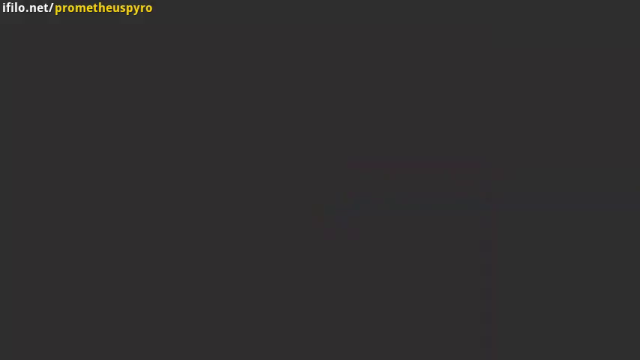

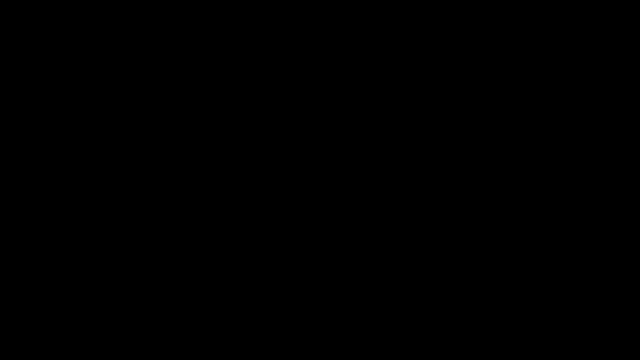

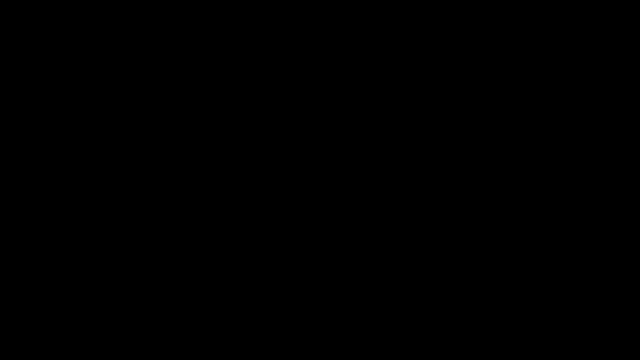

📁 خروجی‌ها در: /content/out_event


In [2]:
# =====================[ Metro Event OCR — On-Detect Only | YOLO + Right Lamp + Tesseract ]=====================
# رفتار: ویدیو عادی جلو می‌رود؛ فقط وقتی "قطار" تشخیص شد و دماغه نزدیک بود:
#        1) برش از نیمهٔ راستِ جلوی قطار
#        2) پیدا کردن چراغ راست
#        3) ROI زیر چراغ → OCR فقط ارقام → چاپ عدد
# خروجی دیباگ (فقط در پایان): frame_debug.jpg / front_debug.jpg / roi_candidate.jpg
# اگر عدد پیدا نشد: 0

# 0) Deps
!apt-get -yqq install tesseract-ocr tesseract-ocr-eng tesseract-ocr-fas >/dev/null
!pip -q install ultralytics opencv-python-headless pytesseract >/dev/null

# 1) Imports
import os, re, sys, cv2, numpy as np, pytesseract, collections
from ultralytics import YOLO
from pytesseract import Output

# Colab-safe show
try:
    from google.colab import files
    from google.colab.patches import cv2_imshow
    def show(img): cv2_imshow(img)
except:
    def show(img): pass

cv2.setUseOptimized(True)
try: cv2.setNumThreads(max(1, os.cpu_count()-1))
except: pass

# -------------------- CONFIG (تنظیمات مهم) --------------------
ASK_UPLOAD          = True              # در Colab فایل آپلود کن؛ اگر False شد از VIDEO_PATH می‌خوانَد
VIDEO_PATH          = "train.mp4"       # مسیر ویدیو وقتی ASK_UPLOAD=False

# ابعاد کاری (برای CPU)
W, H                = 640, 360

# YOLO
YOLO_WEIGHTS        = "yolov8n.pt"      # پیش‌فرض COCO، کلاس 'train' را دارد
YOLO_IMGSZ          = 512
YOLO_CONF           = 0.18              # اگر قطار دور است، 0.12–0.15 هم تست کن
ACCEPTED_CLS        = {"train"}

# فرکانس اجرای YOLO (فقط برای «تشخیص رویداد»)
YOLO_EVERY          = 2                 # هر 2 فریم یک‌بار YOLO؛ اگر همیشه روی همه فریم‌ها می‌خواهی: 1

# «شرطِ نزدیک بودنِ دماغه» تا ریل/وسط اشتباه انتخاب نشود
RIGHT_EDGE_MIN      = 0.90              # x2/W باید >= 0.90 باشد
MIN_W_FRAC          = 0.20              # (x2-x1)/W باید >= 0.20 باشد
LEFT_EDGE_MIN       = 0.35              # x1/W از وسط گذشته باشد

# چراغ راست داخل front
FR_RIGHT_F          = 0.58              # فقط نیمهٔ راستِ front
FR_LOW_Y_F          = 0.58
FR_HIGH_Y_F         = 0.96
FR_AREA_MIN_F       = 0.0006
FR_AREA_MAX_F       = 0.0300
FR_AR_MIN, FR_AR_MAX= 0.55, 1.55
FR_EXT_MIN          = 0.45
BRIGHT_MIN, BR_ADD  = 120, 6
FR_X_MIN_NORM       = 0.72              # چراغ باید نسبتاً راست باشد

# ROI زیر چراغ (ضرایب نسبت به شعاع چراغ)
ROI_XOFF_K          = 1.15
ROI_YOFF_K          = 1.55
ROI_W_K             = 5.8
ROI_H_K             = 2.0

# OCR (Tesseract)
TESS_LANGS          = "eng+fas"
TESS_WHITELIST      = "0123456789۰۱۲۳۴۵۶۷۸۹"
TESS_OEM            = 1
OCR_MIN_CONF        = 13
MAX_DIG             = 4
FORCE_ZFILL         = False             # اگر همیشه 4 رقمی می‌خواهی True کن
STABLE_REPEATS      = 2                 # دو بار عدد یکسان → تایید

# ذخیرهٔ خروجی‌ها
OUT_DIR = "/content/out_event" if os.path.exists("/content") else "./out_event"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------- Utils --------------------
xfarsi = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")
def only_digits(s): return re.sub(r'[^0-9]','',(s or "").translate(xfarsi))
def clamp_digits(d):
    d = only_digits(d)
    if not d: return None
    d = d[:MAX_DIG]
    return d.zfill(4) if FORCE_ZFILL else d

def draw_box(img, box, color=(0,255,0), text=None):
    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    if text:
        tw = 10+8*len(text)
        cv2.rectangle(img,(x1,y1-24),(x1+tw,y1-2),color,-1)
        cv2.putText(img,text,(x1+5,y1-6),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2,cv2.LINE_AA)

def clip_box(x1,y1,x2,y2,w,h):
    x1 = max(0, min(x1, w-1)); y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1)); y2 = max(0, min(y2, h-1))
    if x2<=x1 or y2<=y1: return None
    return (x1,y1,x2,y2)

def front_right(frame, box):
    # نیمۀ راستِ باکس YOLO (جلوِ قطار)
    x1,y1,x2,y2 = box
    bw = max(1, x2-x1)
    xL = max(x1, x2 - int(bw*0.52))
    sub = frame[y1:y2, xL:x2]
    return sub if sub.size else None

def save_img(name,img):
    p=os.path.join(OUT_DIR,name); cv2.imwrite(p,img); show(img)

# -------------------- Lamp finder inside FRONT --------------------
def find_right_lamp_in_front(front):
    h,w = front.shape[:2]
    x0 = int(FR_RIGHT_F*w)
    y1 = int(FR_LOW_Y_F*h); y2 = int(FR_HIGH_Y_F*h)
    zone = front[y1:y2, x0:w]
    if zone.size==0: return None, None, (x0,y1)

    g = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(5,5),0)
    otsu = cv2.threshold(g,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[0]
    thr  = max(BRIGHT_MIN, otsu+BR_ADD)
    _,mask = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    picks=[]
    area_min = FR_AREA_MIN_F * (zone.shape[0]*zone.shape[1])
    area_max = FR_AREA_MAX_F * (zone.shape[0]*zone.shape[1])
    for c in cnts:
        x,y,ww,hh = cv2.boundingRect(c)
        A = cv2.contourArea(c)
        if A<area_min or A>area_max: continue
        ar = ww/float(hh)
        if not (FR_AR_MIN <= ar <= FR_AR_MAX): continue
        extent = A / float(ww*hh + 1e-6)
        if extent < FR_EXT_MIN: continue
        meanv = cv2.mean(g[y:y+hh, x:x+ww])[0]
        cx,cy = x+ww//2, y+hh//2
        picks.append((cx,cy,max(ww,hh)//2,meanv))

    if not picks: return None, None, (x0,y1)

    # راست‌ترین + روشن‌تر
    picks = sorted(picks, key=lambda t: (t[0]/float(zone.shape[1]) + 0.4*(t[3]/255.0)), reverse=True)
    cx,cy,r,meanv = picks[0]
    cx_abs, cy_abs = cx+x0, cy+y1
    if (cx_abs/float(w)) < FR_X_MIN_NORM: return None, None, (x0,y1)

    # ROI زیر چراغ
    rx = int(cx_abs + ROI_XOFF_K*r)
    ry = int(cy_abs + ROI_YOFF_K*r)
    rw = int(ROI_W_K * r); rh = int(ROI_H_K * r)
    box = clip_box(rx, ry, rx+rw, ry+rh, w, h)
    return box, (cx_abs,cy_abs,int(r)), (x0,y1)

# -------------------- OCR --------------------
def binarize_variants(gray):
    v=[]
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1])
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1])
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,7))
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,17,7))
    return v

def read_digits(img_bgr):
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    sc = 520 / max(g.shape)
    if sc>1.0:
        g = cv2.resize(g, (int(g.shape[1]*sc), int(g.shape[0]*sc)), interpolation=cv2.INTER_CUBIC)
    best=""; best_conf=-1
    cfgs = [
        f'--psm 7  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 6  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 13 --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0'
    ]
    for b in binarize_variants(g)[:4]:
        for cfg in cfgs:
            data=pytesseract.image_to_data(b, lang=TESS_LANGS, config=cfg, output_type=Output.DICT)
            toks=[]; confs=[]
            for i in range(len(data['text'])):
                txt=(data['text'][i] or "").strip()
                try: conf=float(data['conf'][i])
                except: conf=-1.0
                if not txt or conf<OCR_MIN_CONF: continue
                d=only_digits(txt)
                if d:
                    toks.append((data['left'][i], d))
                    confs.append(conf)
            digits="".join(d for _,d in sorted(toks,key=lambda t:t[0])) if toks else ""
            if not digits:
                s=pytesseract.image_to_string(b, lang=TESS_LANGS, config=cfg)
                digits=only_digits(s);
                if digits: confs=[OCR_MIN_CONF]
            if digits:
                mconf = (sum(confs)/len(confs)) if confs else OCR_MIN_CONF
                score = (len(digits), mconf)
                if score > (len(best), best_conf):
                    best, best_conf = digits, mconf
    return clamp_digits(best)

def roi_sweep_around(lamp_abs, frame):
    """چند ROI کوچک اطراف محل استاندارد زیر چراغ برای مقاوم‌سازی."""
    h,w = frame.shape[:2]
    cx,cy,r = lamp_abs
    r = max(6, r)
    xfx = [0.95,1.00,1.05]; yfx=[0.90,1.00,1.10]; wfx=[0.90,1.00]; hfx=[0.90,1.00]
    cand=[]
    for fx in xfx:
        for fy in yfx:
            for fw in wfx:
                for fh in hfx:
                    rx = int(cx + ROI_XOFF_K*fx*r)
                    ry = int(cy + ROI_YOFF_K*fy*r)
                    rw = int(ROI_W_K * fw*r); rh = int(ROI_H_K * fh*r)
                    bb = clip_box(rx, ry, rx+rw, ry+rh, w, h)
                    if bb:
                        X1,Y1,X2,Y2 = bb
                        sub = frame[Y1:Y2, X1:X2]
                        if sub.size: cand.append((bb, sub))
    cand = sorted(cand, key=lambda t: ((t[0][2]-t[0][0])*(t[0][3]-t[0][1])))
    return cand[:14]

# -------------------- I/O --------------------
def open_video():
    if ASK_UPLOAD:
        try:
            print("📤 ویدیو را انتخاب کن…")
            up = files.upload()
            if up: return cv2.VideoCapture(next(iter(up)))
        except: pass
    if not os.path.exists(VIDEO_PATH):
        raise FileNotFoundError("ویدیو یافت نشد.")
    return cv2.VideoCapture(VIDEO_PATH)

# -------------------- MAIN (On-Detect Only) --------------------
def run():
    model = YOLO(YOLO_WEIGHTS)
    try: model.fuse()
    except: pass

    cap = open_video()
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

    frame_dbg = np.zeros((H,W,3),np.uint8)
    front_dbg = np.zeros((H,W,3),np.uint8)
    roi_dbg   = np.zeros((H,W,3),np.uint8)

    frame_id = 0
    votes = collections.deque(maxlen=5)

    while True:
        ok, fr = cap.read()
        if not ok:
            # ویدیو تمام شد و رویدادی رخ نداد
            print("0")
            save_img("frame_debug.jpg", frame_dbg)
            save_img("front_debug.jpg", front_dbg)
            save_img("roi_candidate.jpg", roi_dbg)
            break

        frame_id += 1
        fr = cv2.resize(fr,(W,H), interpolation=cv2.INTER_AREA)
        frame_dbg = fr.copy()

        # فقط برای تشخیص رویداد: YOLO هر N فریم
        if frame_id % YOLO_EVERY != 0:
            continue

        # 1) قطار را پیدا کن
        res_box = None
        res = model.predict(fr, imgsz=YOLO_IMGSZ, conf=YOLO_CONF, verbose=False)[0]
        best=None
        for b in res.boxes:
            lbl = res.names[int(b.cls[0])]
            if lbl not in ACCEPTED_CLS: continue
            x1,y1,x2,y2 = map(int, b.xyxy[0].tolist())
            if (x2-x1)<60 or (y2-y1)<60: continue
            area = (x2-x1)*(y2-y1)
            if (best is None) or (area > best[-1]): best=(x1,y1,x2,y2,area)
        if best is None:
            continue
        x1,y1,x2,y2,_ = best
        res_box = clip_box(x1,y1,x2,y2,W,H)

        # 2) فقط وقتی دماغه نزدیک است وارد مرحلهٔ OCR شو
        rnorm = x2/float(W)
        wfrac = (x2-x1)/float(W)
        lnorm = x1/float(W)
        if not (rnorm >= RIGHT_EDGE_MIN and wfrac >= MIN_W_FRAC and lnorm >= LEFT_EDGE_MIN):
            continue

        # 3) برش از نیمهٔ راستِ جلوی قطار
        draw_box(frame_dbg, res_box, (0,255,255), "train")
        front = front_right(fr, res_box)
        if front is None or front.size == 0:
            continue

        # 4) چراغ راست را پیدا کن و ROI زیر آن را بساز
        roi_box, lamp, (xoff,yoff) = find_right_lamp_in_front(front)
        if roi_box is None or lamp is None:
            continue

        # کمی جلوتر برای وضوح بهتر (۲ فریم)
        lastF = fr
        for _ in range(2):
            ok2, f2 = cap.read()
            if not ok2: break
            lastF = cv2.resize(f2,(W,H), interpolation=cv2.INTER_AREA)
        front2 = front_right(lastF, res_box) or front
        roi_box2, lamp2, (xoff2,yoff2) = find_right_lamp_in_front(front2)
        if roi_box2 is None or lamp2 is None:
            roi_box2, lamp2, (xoff2,yoff2) = roi_box, lamp, (xoff,yoff)

        # 5) OCR فقط در لحظهٔ رویداد
        X1,Y1,X2,Y2 = roi_box2
        roi = front2[Y1:Y2, X1:X2]
        roi_dbg = roi.copy() if roi.size else roi_dbg

        # اول ROI اصلی
        digits = read_digits(roi) if roi.size else None
        if digits:
            votes.append(digits)

        # اگر هنوز پایدار نشده، اطراف ROI را هم امتحان کن
        if not digits or votes.count(digits) < STABLE_REPEATS:
            lamp_abs = (xoff2+lamp2[0], yoff2+lamp2[1], lamp2[2])
            for (bb, sub) in roi_sweep_around(lamp_abs, front2):
                d2 = read_digits(sub)
                if d2:
                    votes.append(d2)
                    roi_dbg = sub.copy()
                    if votes.count(d2) >= STABLE_REPEATS:
                        digits = d2
                        break

        # 6) اگر عدد به‌طور پایدار خوانده شد → چاپ و تمام
        if votes and (votes.count(votes[-1]) >= STABLE_REPEATS):
            final = votes[-1]
            draw_box(frame_dbg, res_box, (0,255,255), "LOCK")
            draw_box(front2, roi_box2, (0,255,0), final)
            front_dbg = front2.copy()
            print(final); sys.stdout.flush()
            save_img("frame_debug.jpg", frame_dbg)
            save_img("front_debug.jpg", front_dbg)
            save_img("roi_candidate.jpg", roi_dbg)
            break

    cap.release()
    try: cv2.destroyAllWindows()
    except: pass
    print("📁 خروجی‌ها در:", OUT_DIR)

# RUN
run()
# =====================[ END ]=====================


In [3]:
# =====================[ Metro Event OCR — یک برش از جلوی قطار | YOLO + چراغ راست + Tesseract + AutoTune<1s ]=====================
# رفتـار: ویدیو به‌صورت معمول پخش می‌شود. وقتی "قطار" تشخیص شد و دماغه نزدیک بود:
#   1) فقط «یک برش» از جلوی قطار (نیمۀ راست باکس YOLO) گرفته می‌شود.
#   2) چراغ راست پیدا می‌شود.
#   3) یک ROI زیر چراغ ساخته می‌شود و عدد با Tesseract خوانده می‌شود.
#   4) اگر در همان لحظه خوانده نشد، کد به‌صورت خودکار در <1s سه پارامتر ROI (XOFF, YOFF, W) را تست می‌کند تا «قبل از چاپ نتیجه» جواب درست را بگیرد.
# چاپ خروجی: فقط عدد (۱ تا ۴ رقم). اگر پیدا نشد تا پایان ویدیو: 0
# خروجی دیباگ (در انتها و فقط یک‌بار):
#   - frame_debug.jpg  (کادر YOLO روی فریم اصلی)
#   - front_crop.jpg   (همان یک برش از جلوی قطار + کادر ROI و چراغ روی خودش)
#
# پیش‌نیازها (Ubuntu/Colab):
!apt-get -yqq install tesseract-ocr tesseract-ocr-eng tesseract-ocr-fas >/dev/null
!pip -q install ultralytics opencv-python-headless pytesseract >/dev/null

# -------------------- Imports --------------------
import os, re, sys, time, cv2, numpy as np, pytesseract, collections
from ultralytics import YOLO
from pytesseract import Output

# Colab-safe file upload/show (بدون نمایش خودکار)
try:
    from google.colab import files
    COLAB = True
except:
    COLAB = False

cv2.setUseOptimized(True)
try: cv2.setNumThreads(max(1, os.cpu_count()-1))
except: pass

# -------------------- CONFIG --------------------
ASK_UPLOAD          = True               # اگر Colab هستی و می‌خواهی فایل آپلود کنی
VIDEO_PATH          = "train.mp4"        # وقتی ASK_UPLOAD=False

# ابعاد کاری (سبک برای CPU)
W, H                = 640, 360

# YOLO
YOLO_WEIGHTS        = "yolov8n.pt"
YOLO_IMGSZ          = 512
YOLO_CONF           = 0.18               # اگر قطار دور است 0.12–0.15 را هم می‌توان امتحان کرد
ACCEPTED_CLS        = {"train"}

# هر چند فریم YOLO بزنیم (فقط برای تشخیص رویداد)
YOLO_EVERY          = 1                  # روی همهٔ فریم‌ها → واکنش سریع‌تر

# شرطِ نزدیک بودن دماغه تا ریل/وسط اشتباه انتخاب نشود
RIGHT_EDGE_MIN      = 0.90               # x2/W
MIN_W_FRAC          = 0.20               # (x2-x1)/W
LEFT_EDGE_MIN       = 0.35               # x1/W

# چراغ راست داخل «front» (نیمۀ راست باکس YOLO)
FR_RIGHT_F          = 0.58
FR_LOW_Y_F          = 0.58
FR_HIGH_Y_F         = 0.96
FR_AREA_MIN_F       = 0.0006
FR_AREA_MAX_F       = 0.0300
FR_AR_MIN, FR_AR_MAX= 0.55, 1.55
FR_EXT_MIN          = 0.45
BRIGHT_MIN, BR_ADD  = 120, 6
FR_X_MIN_NORM       = 0.72               # چراغ باید نسبتاً راست باشد

# ROI زیر چراغ (ضرایب نسبت به شعاع چراغ) — سه پارامتری که AutoTune می‌کند
ROI_XOFF_K_DEFAULT  = 1.15
ROI_YOFF_K_DEFAULT  = 1.55
ROI_W_K_DEFAULT     = 5.8
ROI_H_K             = 2.0                # این را ثابت می‌گذاریم (پایداری بهتر)

# AutoTune (فقط روی سه پارامترِ ROI و زیر ۱ثانیه)
AUTOTUNE_BUDGET_SEC = 0.85               # حداکثر زمان امتحان تنظیمات قبل از چاپ نتیجه
# کاندیدها (۳×۲×2 = 12 حالت سبک و سریع)
ROI_XOFF_CANDS      = [1.05, 1.15, 1.25]
ROI_YOFF_CANDS      = [1.45, 1.65]
ROI_W_CANDS         = [5.4, 6.2]

# OCR (Tesseract)
TESS_LANGS          = "eng+fas"
TESS_WHITELIST      = "0123456789۰۱۲۳۴۵۶۷۸۹"
TESS_OEM            = 1
OCR_MIN_CONF        = 13
MAX_DIG             = 4
FORCE_ZFILL         = False              # اگر همیشه 4 رقمی می‌خواهی True کن
STABLE_REPEATS      = 2                  # دو خوانش یکسان → تایید

# خروجی‌ها
OUT_DIR = "/content/out_event" if os.path.exists("/content") else "./out_event"
os.makedirs(OUT_DIR, exist_ok=True)
FRAME_DBG_PATH = os.path.join(OUT_DIR, "frame_debug.jpg")
FRONT_CROP_PATH= os.path.join(OUT_DIR, "front_crop.jpg")

# -------------------- Utils --------------------
xfarsi = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")
def only_digits(s): return re.sub(r'[^0-9]','',(s or "").translate(xfarsi))
def clamp_digits(d):
    d = only_digits(d)
    if not d: return None
    d = d[:MAX_DIG]
    return d.zfill(4) if FORCE_ZFILL else d

def draw_box(img, box, color=(0,255,0), text=None):
    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    if text:
        tw = 10+8*len(text)
        y0 = max(24, y1)
        cv2.rectangle(img,(x1,y0-24),(x1+tw,y0-2),color,-1)
        cv2.putText(img,text,(x1+5,y0-6),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2,cv2.LINE_AA)

def clip_box(x1,y1,x2,y2,w,h):
    x1 = max(0, min(x1, w-1)); y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1)); y2 = max(0, min(y2, h-1))
    if x2<=x1 or y2<=y1: return None
    return (x1,y1,x2,y2)

def front_right(frame, box):
    """تنها یک برش از جلوی قطار (نیمۀ راست باکس YOLO)."""
    x1,y1,x2,y2 = box
    bw = max(1, x2-x1)
    xL = max(x1, x2 - int(bw*0.52))
    sub = frame[y1:y2, xL:x2]
    return sub if sub.size else None

# -------------------- Lamp & ROI --------------------
def find_right_lamp_in_front(front):
    """چراغِ راست را در برش front پیدا می‌کند (مستقل از ROI)."""
    h,w = front.shape[:2]
    x0 = int(FR_RIGHT_F*w)
    y1 = int(FR_LOW_Y_F*h); y2 = int(FR_HIGH_Y_F*h)
    zone = front[y1:y2, x0:w]
    if zone.size==0: return None, None, (x0,y1)

    g = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(5,5),0)
    otsu = cv2.threshold(g,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[0]
    thr  = max(BRIGHT_MIN, otsu+BR_ADD)
    _,mask = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    picks=[]
    area_min = FR_AREA_MIN_F * (zone.shape[0]*zone.shape[1])
    area_max = FR_AREA_MAX_F * (zone.shape[0]*zone.shape[1])
    for c in cnts:
        x,y,ww,hh = cv2.boundingRect(c)
        A = cv2.contourArea(c)
        if A<area_min or A>area_max: continue
        ar = ww/float(hh)
        if not (FR_AR_MIN <= ar <= FR_AR_MAX): continue
        extent = A / float(ww*hh + 1e-6)
        if extent < FR_EXT_MIN: continue
        meanv = cv2.mean(g[y:y+hh, x:x+ww])[0]
        cx,cy = x+ww//2, y+hh//2
        picks.append((cx,cy,max(ww,hh)//2,meanv))

    if not picks: return None, None, (x0,y1)

    picks = sorted(picks, key=lambda t: (t[0]/float(zone.shape[1]) + 0.4*(t[3]/255.0)), reverse=True)
    cx,cy,r,meanv = picks[0]
    cx_abs, cy_abs = cx+x0, cy+y1
    if (cx_abs/float(w)) < FR_X_MIN_NORM: return None, None, (x0,y1)

    return (cx_abs, cy_abs, int(r)), (x0,y1), None  # lamp_abs, offsets, dbg(None)

def roi_from_lamp(front, lamp_abs, xoff_k, yoff_k, w_k, h_k):
    """یک ROI زیر چراغ با ضرایب ورودی می‌سازد (همان «یک ناحیه» که OCR روی آن انجام می‌شود)."""
    h,w = front.shape[:2]
    cx,cy,r = lamp_abs
    r = max(6, r)
    rx = int(cx + xoff_k * r)
    ry = int(cy + yoff_k * r)
    rw = int(w_k * r)
    rh = int(h_k * r)
    return clip_box(rx, ry, rx+rw, ry+rh, w, h)

# -------------------- OCR --------------------
def binarize_variants(gray):
    v=[]
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1])
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1])
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,7))
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,17,7))
    return v

def read_digits(img_bgr):
    """خواندن فقط ارقام (۱ تا ۴ رقم)."""
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    sc = 520 / max(g.shape)
    if sc>1.0:
        g = cv2.resize(g, (int(g.shape[1]*sc), int(g.shape[0]*sc)), interpolation=cv2.INTER_CUBIC)
    best=""; best_conf=-1
    cfgs = [
        f'--psm 7  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 6  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 13 --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0'
    ]
    for b in binarize_variants(g)[:4]:
        for cfg in cfgs:
            data=pytesseract.image_to_data(b, lang=TESS_LANGS, config=cfg, output_type=Output.DICT)
            toks=[]; confs=[]
            for i in range(len(data['text'])):
                txt=(data['text'][i] or "").strip()
                try: conf=float(data['conf'][i])
                except: conf=-1.0
                if not txt or conf<OCR_MIN_CONF: continue
                d=only_digits(txt)
                if d:
                    toks.append((data['left'][i], d))
                    confs.append(conf)
            digits="".join(d for _,d in sorted(toks,key=lambda t:t[0])) if toks else ""
            if not digits:
                s=pytesseract.image_to_string(b, lang=TESS_LANGS, config=cfg)
                digits=only_digits(s);
                if digits: confs=[OCR_MIN_CONF]
            if digits:
                mconf = (sum(confs)/len(confs)) if confs else OCR_MIN_CONF
                score = (len(digits), mconf)
                if score > (len(best), best_conf):
                    best, best_conf = digits, mconf
    return clamp_digits(best)

# -------------------- Video I/O --------------------
def open_video():
    if ASK_UPLOAD and COLAB:
        print("📤 ویدیو را انتخاب کن…")
        up = files.upload()
        if up:
            p = next(iter(up))
            return cv2.VideoCapture(p)
    if not os.path.exists(VIDEO_PATH):
        raise FileNotFoundError("ویدیو یافت نشد.")
    return cv2.VideoCapture(VIDEO_PATH)

# -------------------- Main --------------------
def run():
    model = YOLO(YOLO_WEIGHTS)
    try: model.fuse()
    except: pass

    cap = open_video()
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

    frame_dbg = np.zeros((H,W,3),np.uint8)
    front_annot = None  # برای ذخیرهٔ همان «یک برش» با توضیحات
    votes = collections.deque(maxlen=4)

    frame_id = 0
    while True:
        ok, fr = cap.read()
        if not ok:
            # ویدیو تمام شد، عددی پیدا نشد
            print("0")
            if front_annot is None:
                cv2.imwrite(FRAME_DBG_PATH, frame_dbg)
            else:
                cv2.imwrite(FRONT_CROP_PATH, front_annot)
                cv2.imwrite(FRAME_DBG_PATH, frame_dbg)
            break

        frame_id += 1
        fr = cv2.resize(fr,(W,H), interpolation=cv2.INTER_AREA)
        frame_dbg = fr.copy()

        # فقط برای تشخیص رویداد: YOLO هر N فریم
        if frame_id % YOLO_EVERY != 0:
            continue

        # --- 1) تشخیص قطار ---
        res = model.predict(fr, imgsz=YOLO_IMGSZ, conf=YOLO_CONF, verbose=False)[0]
        best=None
        for b in res.boxes:
            lbl = res.names[int(b.cls[0])]
            if lbl not in ACCEPTED_CLS: continue
            x1,y1,x2,y2 = map(int, b.xyxy[0].tolist())
            if (x2-x1)<60 or (y2-y1)<60: continue
            area = (x2-x1)*(y2-y1)
            if (best is None) or (area > best[-1]): best=(x1,y1,x2,y2,area)
        if best is None:
            continue

        x1,y1,x2,y2,_ = best
        rnorm = x2/float(W); wfrac=(x2-x1)/float(W); lnorm=x1/float(W)
        if not (rnorm >= RIGHT_EDGE_MIN and wfrac >= MIN_W_FRAC and lnorm >= LEFT_EDGE_MIN):
            # هنوز دماغه به اندازهٔ کافی نزدیک نیست
            continue

        # --- 2) فقط یک برش از جلوی قطار ---
        box = clip_box(x1,y1,x2,y2,W,H)
        draw_box(frame_dbg, box, (0,255,255), "train")
        front = front_right(fr, box)
        if front is None or front.size==0:
            continue

        # برای وضوح بهتر، یک نگاه جلو (بدون ایجاد برش‌های دیگر؛ فقط جایگزین همین front)
        lastF = fr
        for _ in range(2):
            ok2, f2 = cap.read()
            if not ok2: break
            lastF = cv2.resize(f2,(W,H), interpolation=cv2.INTER_AREA)
        front2 = front_right(lastF, box) or front
        front_vis = front2.copy()

        # --- 3) چراغ راست را در همین یک برش پیدا کن ---
        lamp_abs, offsets, _ = find_right_lamp_in_front(front2)
        if lamp_abs is None:
            # نتوانست چراغ را در front پیدا کند → منتظر فریم بعدی بمان
            continue

        # چراغ را روی front علامت بزنیم (فقط روی همان یک برش)
        cx,cy,r = lamp_abs
        cv2.circle(front_vis,(cx,cy),int(r),(0,255,255),2)

        # --- 4) یک ROI بساز و OCR؛ اگر نشد → AutoTune سه پارامتر در <1s ---
        t_deadline = time.monotonic() + AUTOTUNE_BUDGET_SEC
        tried_any = False
        final_digits = None
        final_roi = None

        # اول با پیش‌فرض‌ها
        roi_box = roi_from_lamp(front2, lamp_abs, ROI_XOFF_K_DEFAULT, ROI_YOFF_K_DEFAULT, ROI_W_K_DEFAULT, ROI_H_K)
        if roi_box is not None:
            X1,Y1,X2,Y2 = roi_box
            roi = front2[Y1:Y2, X1:X2]
            if roi.size:
                tried_any = True
                d = read_digits(roi)
                if d:
                    votes.append(d)
                    if votes.count(d) >= STABLE_REPEATS:
                        final_digits = d
                        final_roi = roi_box

        # اگر هنوز جواب قطعی نداریم، در بازۀ زمانی کوتاه، ۳ پارامتر ROI را اتوماتیک امتحان کن
        if final_digits is None:
            for xk in ROI_XOFF_CANDS:
                for yk in ROI_YOFF_CANDS:
                    for wk in ROI_W_CANDS:
                        if time.monotonic() > t_deadline: break
                        roi_box = roi_from_lamp(front2, lamp_abs, xk, yk, wk, ROI_H_K)
                        if roi_box is None: continue
                        X1,Y1,X2,Y2 = roi_box
                        roi = front2[Y1:Y2, X1:X2]
                        if not roi.size: continue
                        tried_any = True
                        d = read_digits(roi)
                        if d:
                            votes.append(d)
                            if votes.count(d) >= STABLE_REPEATS:
                                final_digits = d
                                final_roi = roi_box
                                break
                    if final_digits is not None or time.monotonic() > t_deadline: break
                if final_digits is not None or time.monotonic() > t_deadline: break

        # --- 5) اگر خوانده شد → چاپ و ذخیرهٔ حداقلی (تنها یک برش) ---
        if final_digits is not None:
            # روی همان یک برش، ROI و عدد را هم می‌نویسیم
            X1,Y1,X2,Y2 = final_roi
            cv2.rectangle(front_vis,(X1,Y1),(X2,Y2),(0,255,0),2)
            cv2.putText(front_vis, final_digits, (X1+4, max(24,Y1-6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2, cv2.LINE_AA)

            # ذخیرهٔ حداقلی:
            cv2.imwrite(FRONT_CROP_PATH, front_vis)   # فقط یک برش (با حاشیه‌های نشانه‌گذاری)
            cv2.imwrite(FRAME_DBG_PATH, frame_dbg)    # فریم کامل با کادر YOLO (دیباگ؛ برش نیست)

            # فقط عدد را چاپ کن
            print(final_digits); sys.stdout.flush()
            break

        # اگر تلاش کرد ولی هنوز جواب قطعی نشد، ادامه بده تا فریم‌های بعدی (ویدیو پخش می‌شود)
        # اگر تا آخر ویدیو هم نشد، بیرون حلقه 0 چاپ می‌کنیم.

    cap.release()
    try: cv2.destroyAllWindows()
    except: pass

# RUN
run()


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
📤 ویدیو را انتخاب کن…


Saving train.mp4 to train (2).mp4


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [4]:
# =====================[ Metro Event OCR — یک برش از جلوی قطار | YOLO + چراغ راست + Tesseract + AutoTune<1s ]=====================
!apt-get -yqq install tesseract-ocr tesseract-ocr-eng tesseract-ocr-fas >/dev/null
!pip -q install ultralytics opencv-python-headless pytesseract >/dev/null

import os, re, sys, time, cv2, numpy as np, pytesseract, collections
from ultralytics import YOLO
from pytesseract import Output

try:
    from google.colab import files
    COLAB = True
except:
    COLAB = False

cv2.setUseOptimized(True)
try: cv2.setNumThreads(max(1, os.cpu_count()-1))
except: pass

# -------------------- CONFIG --------------------
ASK_UPLOAD          = True
VIDEO_PATH          = "train.mp4"
W, H                = 640, 360

YOLO_WEIGHTS        = "yolov8n.pt"
YOLO_IMGSZ          = 512
YOLO_CONF           = 0.18
ACCEPTED_CLS        = {"train"}
YOLO_EVERY          = 1

RIGHT_EDGE_MIN      = 0.90
MIN_W_FRAC          = 0.20
LEFT_EDGE_MIN       = 0.35

FR_RIGHT_F          = 0.58
FR_LOW_Y_F          = 0.58
FR_HIGH_Y_F         = 0.96
FR_AREA_MIN_F       = 0.0006
FR_AREA_MAX_F       = 0.0300
FR_AR_MIN, FR_AR_MAX= 0.55, 1.55
FR_EXT_MIN          = 0.45
BRIGHT_MIN, BR_ADD  = 120, 6
FR_X_MIN_NORM       = 0.72

ROI_XOFF_K_DEFAULT  = 1.15
ROI_YOFF_K_DEFAULT  = 1.55
ROI_W_K_DEFAULT     = 5.8
ROI_H_K             = 2.0

AUTOTUNE_BUDGET_SEC = 0.85
ROI_XOFF_CANDS      = [1.05, 1.15, 1.25]
ROI_YOFF_CANDS      = [1.45, 1.65]
ROI_W_CANDS         = [5.4, 6.2]

TESS_LANGS          = "eng+fas"
TESS_WHITELIST      = "0123456789۰۱۲۳۴۵۶۷۸۹"
TESS_OEM            = 1
OCR_MIN_CONF        = 13
MAX_DIG             = 4
FORCE_ZFILL         = False
STABLE_REPEATS      = 2

OUT_DIR = "/content/out_event" if os.path.exists("/content") else "./out_event"
os.makedirs(OUT_DIR, exist_ok=True)
FRAME_DBG_PATH = os.path.join(OUT_DIR, "frame_debug.jpg")
FRONT_CROP_PATH= os.path.join(OUT_DIR, "front_crop.jpg")

# -------------------- Utils --------------------
xfarsi = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")
def only_digits(s): return re.sub(r'[^0-9]','',(s or "").translate(xfarsi))
def clamp_digits(d):
    d = only_digits(d)
    if not d: return None
    d = d[:MAX_DIG]
    return d.zfill(4) if FORCE_ZFILL else d

def draw_box(img, box, color=(0,255,0), text=None):
    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    if text:
        tw = 10+8*len(text)
        y0 = max(24, y1)
        cv2.rectangle(img,(x1,y0-24),(x1+tw,y0-2),color,-1)
        cv2.putText(img,text,(x1+5,y0-6),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2,cv2.LINE_AA)

def clip_box(x1,y1,x2,y2,w,h):
    x1 = max(0, min(x1, w-1)); y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1)); y2 = max(0, min(y2, h-1))
    if x2<=x1 or y2<=y1: return None
    return (x1,y1,x2,y2)

def front_right(frame, box):
    x1,y1,x2,y2 = box
    bw = max(1, x2-x1)
    xL = max(x1, x2 - int(bw*0.52))
    sub = frame[y1:y2, xL:x2]
    return sub if sub.size else None

# -------------------- Lamp & ROI --------------------
def find_right_lamp_in_front(front):
    h,w = front.shape[:2]
    x0 = int(FR_RIGHT_F*w)
    y1 = int(FR_LOW_Y_F*h); y2 = int(FR_HIGH_Y_F*h)
    zone = front[y1:y2, x0:w]
    if zone.size==0: return None, None, (x0,y1)

    g = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(5,5),0)
    otsu = cv2.threshold(g,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[0]
    thr  = max(BRIGHT_MIN, otsu+BR_ADD)
    _,mask = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    picks=[]
    area_min = FR_AREA_MIN_F * (zone.shape[0]*zone.shape[1])
    area_max = FR_AREA_MAX_F * (zone.shape[0]*zone.shape[1])
    for c in cnts:
        x,y,ww,hh = cv2.boundingRect(c)
        A = cv2.contourArea(c)
        if A<area_min or A>area_max: continue
        ar = ww/float(hh)
        if not (FR_AR_MIN <= ar <= FR_AR_MAX): continue
        extent = A / float(ww*hh + 1e-6)
        if extent < FR_EXT_MIN: continue
        meanv = cv2.mean(g[y:y+hh, x:x+ww])[0]
        cx,cy = x+ww//2, y+hh//2
        picks.append((cx,cy,max(ww,hh)//2,meanv))

    if not picks: return None, None, (x0,y1)
    picks = sorted(picks, key=lambda t: (t[0]/float(zone.shape[1]) + 0.4*(t[3]/255.0)), reverse=True)
    cx,cy,r,meanv = picks[0]
    cx_abs, cy_abs = cx+x0, cy+y1
    if (cx_abs/float(w)) < FR_X_MIN_NORM: return None, None, (x0,y1)
    return (cx_abs, cy_abs, int(r)), (x0,y1), None

def roi_from_lamp(front, lamp_abs, xoff_k, yoff_k, w_k, h_k):
    h,w = front.shape[:2]
    cx,cy,r = lamp_abs
    r = max(6, r)
    rx = int(cx + xoff_k * r)
    ry = int(cy + yoff_k * r)
    rw = int(w_k * r)
    rh = int(h_k * r)
    return clip_box(rx, ry, rx+rw, ry+rh, w, h)

# -------------------- OCR --------------------
def binarize_variants(gray):
    v=[]
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1])
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1])
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,7))
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,17,7))
    return v

def read_digits(img_bgr):
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    sc = 520 / max(g.shape)
    if sc>1.0:
        g = cv2.resize(g, (int(g.shape[1]*sc), int(g.shape[0]*sc)), interpolation=cv2.INTER_CUBIC)
    best=""; best_conf=-1
    cfgs = [
        f'--psm 7  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 6  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 13 --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0'
    ]
    for b in binarize_variants(g)[:4]:
        for cfg in cfgs:
            data=pytesseract.image_to_data(b, lang=TESS_LANGS, config=cfg, output_type=Output.DICT)
            toks=[]; confs=[]
            for i in range(len(data['text'])):
                txt=(data['text'][i] or "").strip()
                try: conf=float(data['conf'][i])
                except: conf=-1.0
                if not txt or conf<OCR_MIN_CONF: continue
                d=only_digits(txt)
                if d:
                    toks.append((data['left'][i], d)); confs.append(conf)
            digits="".join(d for _,d in sorted(toks,key=lambda t:t[0])) if toks else ""
            if not digits:
                s=pytesseract.image_to_string(b, lang=TESS_LANGS, config=cfg)
                digits=only_digits(s);
                if digits: confs=[OCR_MIN_CONF]
            if digits:
                mconf = (sum(confs)/len(confs)) if confs else OCR_MIN_CONF
                score = (len(digits), mconf)
                if score > (len(best), best_conf):
                    best, best_conf = digits, mconf
    return clamp_digits(best)

# -------------------- Video I/O --------------------
def open_video():
    if ASK_UPLOAD and COLAB:
        print("📤 ویدیو را انتخاب کن…")
        up = files.upload()
        if up:
            p = next(iter(up))
            return cv2.VideoCapture(p)
    if not os.path.exists(VIDEO_PATH):
        raise FileNotFoundError("ویدیو یافت نشد.")
    return cv2.VideoCapture(VIDEO_PATH)

# -------------------- Main --------------------
def run():
    model = YOLO(YOLO_WEIGHTS)
    try: model.fuse()
    except: pass

    cap = open_video()
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

    frame_dbg = np.zeros((H,W,3),np.uint8)
    front_annot = None
    votes = collections.deque(maxlen=4)

    frame_id = 0
    while True:
        ok, fr = cap.read()
        if not ok:
            print("0")
            if front_annot is None:
                cv2.imwrite(FRAME_DBG_PATH, frame_dbg)
            else:
                cv2.imwrite(FRONT_CROP_PATH, front_annot)
                cv2.imwrite(FRAME_DBG_PATH, frame_dbg)
            break

        frame_id += 1
        fr = cv2.resize(fr,(W,H), interpolation=cv2.INTER_AREA)
        frame_dbg = fr.copy()

        if frame_id % YOLO_EVERY != 0:
            continue

        res = model.predict(fr, imgsz=YOLO_IMGSZ, conf=YOLO_CONF, verbose=False)[0]
        best=None
        for b in res.boxes:
            lbl = res.names[int(b.cls[0])]
            if lbl not in ACCEPTED_CLS: continue
            x1,y1,x2,y2 = map(int, b.xyxy[0].tolist())
            if (x2-x1)<60 or (y2-y1)<60: continue
            area = (x2-x1)*(y2-y1)
            if (best is None) or (area > best[-1]): best=(x1,y1,x2,y2,area)
        if best is None:
            continue

        x1,y1,x2,y2,_ = best
        rnorm = x2/float(W); wfrac=(x2-x1)/float(W); lnorm=x1/float(W)
        if not (rnorm >= RIGHT_EDGE_MIN and wfrac >= MIN_W_FRAC and lnorm >= LEFT_EDGE_MIN):
            continue

        box = clip_box(x1,y1,x2,y2,W,H)
        draw_box(frame_dbg, box, (0,255,255), "train")
        front = front_right(fr, box)
        if front is None or front.size==0:
            continue

        # ---- FIX: بدون استفاده از 'or' روی ndarray
        lastF = fr
        for _ in range(2):
            ok2, f2 = cap.read()
            if not ok2: break
            lastF = cv2.resize(f2,(W,H), interpolation=cv2.INTER_AREA)

        front2 = front_right(lastF, box)
        if front2 is None or front2.size == 0:
            front2 = front

        if front2 is None or front2.size == 0:
            continue

        front_vis = front2.copy()

        lamp_abs, offsets, _ = find_right_lamp_in_front(front2)
        if lamp_abs is None:
            continue

        cx,cy,r = lamp_abs
        cv2.circle(front_vis,(cx,cy),int(r),(0,255,255),2)

        t_deadline = time.monotonic() + AUTOTUNE_BUDGET_SEC
        votes.clear()
        final_digits = None
        final_roi = None

        roi_box = roi_from_lamp(front2, lamp_abs, ROI_XOFF_K_DEFAULT, ROI_YOFF_K_DEFAULT, ROI_W_K_DEFAULT, ROI_H_K)
        if roi_box is not None:
            X1,Y1,X2,Y2 = roi_box
            roi = front2[Y1:Y2, X1:X2]
            if roi.size:
                d = read_digits(roi)
                if d:
                    votes.append(d)
                    if votes.count(d) >= STABLE_REPEATS:
                        final_digits = d
                        final_roi = roi_box

        if final_digits is None:
            for xk in ROI_XOFF_CANDS:
                for yk in ROI_YOFF_CANDS:
                    for wk in ROI_W_CANDS:
                        if time.monotonic() > t_deadline: break
                        roi_box = roi_from_lamp(front2, lamp_abs, xk, yk, wk, ROI_H_K)
                        if roi_box is None: continue
                        X1,Y1,X2,Y2 = roi_box
                        roi = front2[Y1:Y2, X1:X2]
                        if not roi.size: continue
                        d = read_digits(roi)
                        if d:
                            votes.append(d)
                            if votes.count(d) >= STABLE_REPEATS:
                                final_digits = d
                                final_roi = roi_box
                                break
                    if final_digits is not None or time.monotonic() > t_deadline: break
                if final_digits is not None or time.monotonic() > t_deadline: break

        if final_digits is not None:
            X1,Y1,X2,Y2 = final_roi
            cv2.rectangle(front_vis,(X1,Y1),(X2,Y2),(0,255,0),2)
            cv2.putText(front_vis, final_digits, (X1+4, max(24,Y1-6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2, cv2.LINE_AA)
            cv2.imwrite(FRONT_CROP_PATH, front_vis)
            cv2.imwrite(FRAME_DBG_PATH, frame_dbg)
            print(final_digits); sys.stdout.flush()
            break

    cap.release()
    try: cv2.destroyAllWindows()
    except: pass

# RUN
run()


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
📤 ویدیو را انتخاب کن…


Saving train.mp4 to train (3).mp4
0


In [5]:
# =====================[ Metro Front OCR — One-shot crop | YOLO + Right Lamp + Tesseract ]=====================
# خروجی: فقط عدد 1..4 رقمی (مثلاً 7 / 362 / 0001). اگر پیدا نشد: 0
# منطق: تا وقتی دماغهٔ قطار دیده نشود، هیچ برشی نمی‌زنیم. پس از قفل روی چراغ راست، یک برش زیر چراغ → OCR → توقف.

# 0) Deps
!apt-get -yqq install tesseract-ocr tesseract-ocr-eng tesseract-ocr-fas >/dev/null
!pip -q install ultralytics opencv-python-headless pytesseract >/dev/null

# 1) Imports
import os, re, sys, time, cv2, numpy as np, pytesseract, collections
from ultralytics import YOLO
from pytesseract import Output
try:
    from google.colab import files
    from google.colab.patches import cv2_imshow
    COLAB=True
    def show(img): cv2_imshow(img)
except:
    COLAB=False
    def show(img): pass

cv2.setUseOptimized(True)
try: cv2.setNumThreads(max(1, os.cpu_count()-1))
except: pass

# -------------------- CONFIG --------------------
# منبع ویدیو: فایل/آپلود/وب‌کم/RTSP
SOURCE            = "auto"   # "auto" (آپلود در کولَب) یا مسیر فایل مثل "train.mp4" یا عدد 0 برای وب‌کم یا رشته RTSP
RESIZE_W, RESIZE_H= 640, 360

# YOLO (صرفاً برای تایید «قطار»؛ برش را چراغ راست تعیین می‌کند)
YOLO_WEIGHTS      = "yolov8n.pt"
YOLO_IMGSZ        = 512
YOLO_CONF         = 0.18
ACCEPTED_CLS      = {"train"}
YOLO_EVERY        = 1     # روی همهٔ فریم‌ها، چون سبک است و به «زیر یک ثانیه» کمک می‌کند

# قفل دماغه با چراغ راست (بدون تعمیر دستی)
RIGHT_EDGE_MIN    = 0.90   # x2/W باکس YOLO باید نزدیک لبهٔ راست باشد
LEFT_EDGE_MIN     = 0.35   # x1/W از وسط گذشته باشد
MIN_W_FRAC        = 0.20   # (x2-x1)/W حداقل پهنای قطار

# جستجوی چراغ راست در front (بدون YOLO)
FR_RIGHT_F        = 0.58
FR_LOW_Y_F        = 0.58
FR_HIGH_Y_F       = 0.96
FR_AREA_MIN_F     = 0.0006
FR_AREA_MAX_F     = 0.0300
FR_AR_MIN, FR_AR_MAX = 0.55, 1.55
FR_EXT_MIN        = 0.45
BRIGHT_MIN, BR_ADD= 120, 6
FR_X_MIN_NORM     = 0.72

# یک برش زیرِ چراغ (پارامترها خودکار، اما هر فریم فقط یک برش زده می‌شود)
ROI_XOFF_K        = 1.15   # افست افقی = k*r
ROI_YOFF_K        = 1.55   # افست عمودی = k*r
ROI_W_K           = 5.8    # عرض = k*r
ROI_H_K           = 2.0    # ارتفاع = k*r

# OCR
TESS_LANGS        = "eng+fas"
TESS_WHITELIST    = "0123456789۰۱۲۳۴۵۶۷۸۹"
TESS_OEM          = 1
OCR_MIN_CONF      = 13
MAX_DIG           = 4
FORCE_ZFILL       = False  # اگر همیشه 4 رقمی لازم داری True کن

# Debug (فقط آخرین 3 تصویر ذخیره/نمایش می‌شود)
OUT_DIR = "/content/metro_out" if os.path.exists("/content") else "./metro_out"
os.makedirs(OUT_DIR, exist_ok=True)
PATH_FRAME = os.path.join(OUT_DIR, "frame_debug.jpg")
PATH_FRONT = os.path.join(OUT_DIR, "front_debug.jpg")
PATH_ROI   = os.path.join(OUT_DIR, "roi_debug.jpg")

# -------------------- Utils --------------------
xfarsi = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")
def only_digits(s): return re.sub(r'[^0-9]','',(s or "").translate(xfarsi))
def clamp_digits(d):
    d = only_digits(d)
    if not d: return None
    d = d[:MAX_DIG]
    return d.zfill(4) if FORCE_ZFILL else d

def draw_box(img, box, color=(0,255,0), text=None):
    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    if text:
        y0 = max(24, y1)
        cv2.rectangle(img,(x1,y0-24),(x1+10+8*len(text),y0-2),color,-1)
        cv2.putText(img,text,(x1+5,y0-6),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2,cv2.LINE_AA)

def clip_box(x1,y1,x2,y2,w,h):
    x1 = max(0, min(x1, w-1)); y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1)); y2 = max(0, min(y2, h-1))
    if x2<=x1 or y2<=y1: return None
    return (x1,y1,x2,y2)

def front_right(frame, box):
    x1,y1,x2,y2 = box
    bw = max(1, x2-x1)
    xL = max(x1, x2 - int(bw*0.52))   # نیمهٔ راست باکس قطار
    sub = frame[y1:y2, xL:x2]
    return sub if sub.size else None

# -------------------- Lamp + ROI --------------------
def find_right_lamp_in_front(front):
    """چراغ راست را داخل ناحیهٔ جلو‌ـ‌راست باکس YOLO پیدا می‌کند. خروجی: (cx,cy,r) یا None"""
    h,w = front.shape[:2]
    x0 = int(FR_RIGHT_F*w)
    y1 = int(FR_LOW_Y_F*h); y2 = int(FR_HIGH_Y_F*h)
    zone = front[y1:y2, x0:w]
    if zone.size==0: return None

    g = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(5,5),0)
    otsu = cv2.threshold(g,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[0]
    thr  = max(BRIGHT_MIN, otsu+BR_ADD)
    _,mask = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    picks=[]
    area_min = FR_AREA_MIN_F * (zone.shape[0]*zone.shape[1])
    area_max = FR_AREA_MAX_F * (zone.shape[0]*zone.shape[1])
    for c in cnts:
        x,y,ww,hh = cv2.boundingRect(c)
        A = cv2.contourArea(c)
        if A<area_min or A>area_max: continue
        ar = ww/float(hh)
        if not (FR_AR_MIN <= ar <= FR_AR_MAX): continue
        extent = A / float(ww*hh + 1e-6)
        if extent < FR_EXT_MIN: continue
        meanv = cv2.mean(g[y:y+hh, x:x+ww])[0]
        cx,cy = x+ww//2, y+hh//2
        picks.append((cx,cy,max(ww,hh)//2,meanv))

    if not picks: return None
    # راست‌ترین و پرنورترین
    picks = sorted(picks, key=lambda t: (t[0]/float(zone.shape[1]) + 0.4*(t[3]/255.0)), reverse=True)
    cx,cy,r,meanv = picks[0]
    cx_abs, cy_abs = cx+x0, cy+y1
    if (cx_abs/float(w)) < FR_X_MIN_NORM: return None
    return (cx_abs, cy_abs, int(max(6,r)))

def roi_from_lamp(front, lamp_abs):
    """یک برش «زیر چراغ راست» برمی‌گرداند (فقط یک برش در هر فریم)."""
    h,w = front.shape[:2]
    cx,cy,r = lamp_abs
    rx = int(cx + ROI_XOFF_K * r)
    ry = int(cy + ROI_YOFF_K * r)
    rw = int(ROI_W_K * r)
    rh = int(ROI_H_K * r)
    return clip_box(rx, ry, rx+rw, ry+rh, w, h)

# -------------------- OCR --------------------
def binarize_variants(gray):
    v=[]
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1])
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1])
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,7))
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,17,7))
    return v

def read_digits(img_bgr):
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    sc = 520 / max(g.shape)
    if sc>1.0:
        g = cv2.resize(g, (int(g.shape[1]*sc), int(g.shape[0]*sc)), interpolation=cv2.INTER_CUBIC)

    best=""; best_conf=-1
    cfgs = [
        f'--psm 7  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 6  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 13 --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0'
    ]
    for b in binarize_variants(g)[:4]:
        for cfg in cfgs:
            data=pytesseract.image_to_data(b, lang=TESS_LANGS, config=cfg, output_type=Output.DICT)
            toks=[]; confs=[]
            for i in range(len(data['text'])):
                txt=(data['text'][i] or "").strip()
                try: conf=float(data['conf'][i])
                except: conf=-1.0
                if not txt or conf<OCR_MIN_CONF: continue
                d=only_digits(txt)
                if d:
                    toks.append((data['left'][i], d)); confs.append(conf)
            digits="".join(d for _,d in sorted(toks,key=lambda t:t[0])) if toks else ""
            if not digits:
                s=pytesseract.image_to_string(b, lang=TESS_LANGS, config=cfg)
                digits=only_digits(s);
                if digits: confs=[OCR_MIN_CONF]
            if digits:
                mconf = (sum(confs)/len(confs)) if confs else OCR_MIN_CONF
                score = (len(digits), mconf)  # اول طول، بعد میانگین کانفیدنس
                if score > (len(best), best_conf):
                    best, best_conf = digits, mconf
    return clamp_digits(best)

# -------------------- I/O --------------------
def open_source():
    if SOURCE=="auto" and COLAB:
        print("📤 ویدیو را انتخاب کن…")
        up = files.upload()
        if up:
            p = next(iter(up))
            return cv2.VideoCapture(p)
        else:
            raise RuntimeError("فایلی انتخاب نشد.")
    elif isinstance(SOURCE, int) or (isinstance(SOURCE,str) and SOURCE.startswith("rtsp")):
        return cv2.VideoCapture(SOURCE)
    else:
        if not os.path.exists(SOURCE):
            raise FileNotFoundError("مسیر ویدیو پیدا نشد.")
        return cv2.VideoCapture(SOURCE)

# -------------------- MAIN --------------------
def run():
    model = YOLO(YOLO_WEIGHTS)
    try: model.fuse()
    except: pass

    cap = open_source()
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

    while True:
        ok, fr = cap.read()
        if not ok:
            print("0")
            break

        fr = cv2.resize(fr,(RESIZE_W,RESIZE_H), interpolation=cv2.INTER_AREA)
        frame_vis = fr.copy()

        # YOLO (فقط تایید وجود قطار و موقعیت کلی آن)
        res = model.predict(fr, imgsz=YOLO_IMGSZ, conf=YOLO_CONF, verbose=False)[0]
        best=None
        for b in res.boxes:
            lbl = res.names[int(b.cls[0])]
            if lbl not in ACCEPTED_CLS: continue
            x1,y1,x2,y2 = map(int, b.xyxy[0].tolist())
            if (x2-x1)<60 or (y2-y1)<60: continue
            area = (x2-x1)*(y2-y1)
            if (best is None) or (area > best[-1]): best=(x1,y1,x2,y2,area)
        if best is None:
            continue

        x1,y1,x2,y2,_ = best
        rnorm = x2/float(RESIZE_W); lnorm = x1/float(RESIZE_W); wfrac=(x2-x1)/float(RESIZE_W)
        if not (rnorm >= RIGHT_EDGE_MIN and lnorm >= LEFT_EDGE_MIN and wfrac >= MIN_W_FRAC):
            # هنوز دماغه وارد نشده (مثلاً وسط قطار/ریل)
            continue

        # جلو‌ـ‌راست باکس قطار
        box = clip_box(x1,y1,x2,y2, RESIZE_W, RESIZE_H)
        draw_box(frame_vis, box, (0,255,255), "train")
        front = front_right(fr, box)
        if front is None or front.size==0:
            continue

        # چراغ راست
        lamp_abs = find_right_lamp_in_front(front)
        if lamp_abs is None:
            continue

        # برش «یکتایی» زیر چراغ
        roi_box = roi_from_lamp(front, lamp_abs)
        if roi_box is None:
            continue
        X1,Y1,X2,Y2 = roi_box
        roi = front[Y1:Y2, X1:X2]
        if roi.size==0:
            continue

        # OCR
        digits = read_digits(roi)
        # ذخیرهٔ سه تصویر نهایی برای بررسی
        fdbg = front.copy()
        cx,cy,r = lamp_abs
        cv2.circle(fdbg,(cx,cy),int(r),(0,255,255),2)
        cv2.rectangle(fdbg,(X1,Y1),(X2,Y2),(0,255,0),2)
        cv2.putText(fdbg, digits if digits else "no-digits",(X1+4,max(24,Y1-6)),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,255,0),2,cv2.LINE_AA)

        cv2.imwrite(PATH_FRAME, frame_vis)
        cv2.imwrite(PATH_FRONT, fdbg)
        cv2.imwrite(PATH_ROI, roi)

        print(digits if digits else "0")  # فقط عدد یا 0
        break

    cap.release()
    try: cv2.destroyAllWindows()
    except: pass
    print("📁 Debug:", OUT_DIR)

# RUN
run()
# =====================[ END ]=====================


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
📤 ویدیو را انتخاب کن…


Saving train.mp4 to train (4).mp4
0
📁 Debug: /content/metro_out


In [6]:
# =====================[ Metro Front OCR — One-shot crop ONLY when train found ]=====================
# خروجی: فقط عدد 1..4 رقمی (مثلاً 7 / 362 / 0001). اگر نشد: 0
# قانون: تا وقتی train + چراغ راست تایید نشوند، هیچ برشی انجام نمی‌شود. به‌محض تایید، یک برش → OCR → توقف.

# 0) Deps
!apt-get -yqq install tesseract-ocr tesseract-ocr-eng tesseract-ocr-fas >/dev/null
!pip -q install ultralytics opencv-python-headless pytesseract >/dev/null

# 1) Imports
import os, re, sys, cv2, numpy as np, pytesseract
from ultralytics import YOLO
from pytesseract import Output

try:
    from google.colab import files
    from google.colab.patches import cv2_imshow
    COLAB=True
    def show(img): cv2_imshow(img)
except:
    COLAB=False
    def show(img): pass

cv2.setUseOptimized(True)
try: cv2.setNumThreads(max(1, os.cpu_count()-1))
except: pass

# -------------------- CONFIG --------------------
SOURCE            = "auto"   # "auto" در کولَب (آپلود)، یا مسیر فایل/0 برای وب‌کم/RTSP
W, H              = 640, 360

# YOLO: فقط تایید «قطار»؛ برش را چراغ راست تعیین می‌کند
YOLO_WEIGHTS      = "yolov8n.pt"
YOLO_IMGSZ        = 512
YOLO_CONF         = 0.18
ACCEPTED          = {"train"}

# قفل دماغه (برای جلوگیری از وسط قطار/ریل)
RIGHT_EDGE_MIN    = 0.90   # x2/W نزدیک راست
LEFT_EDGE_MIN     = 0.35   # x1/W از وسط بگذرد
MIN_W_FRAC        = 0.20   # (x2-x1)/W حداقل پهنا

# چراغ راست (در frontِ باکس YOLO)
FR_RIGHT_F        = 0.58
FR_LOW_Y_F        = 0.58
FR_HIGH_Y_F       = 0.96
FR_AREA_MIN_F     = 0.0006
FR_AREA_MAX_F     = 0.0300
FR_AR_MIN, FR_AR_MAX = 0.55, 1.55
FR_EXT_MIN        = 0.45
FR_X_MIN_NORM     = 0.72
BRIGHT_MIN, BR_ADD= 120, 6

# یک برش زیر چراغ
ROI_XOFF_K        = 1.15
ROI_YOFF_K        = 1.55
ROI_W_K           = 5.8
ROI_H_K           = 2.0

# OCR
TESS_LANGS        = "eng+fas"
TESS_WHITELIST    = "0123456789۰۱۲۳۴۵۶۷۸۹"
TESS_OEM          = 1
OCR_MIN_CONF      = 13
MAX_DIG           = 4
FORCE_ZFILL       = False

# Debug: فقط وقتی برش انجام شد ذخیره می‌کنیم
OUT_DIR = "/content/metro_out" if os.path.exists("/content") else "./metro_out"
os.makedirs(OUT_DIR, exist_ok=True)
F_FRAME = os.path.join(OUT_DIR, "frame_debug.jpg")
F_FRONT = os.path.join(OUT_DIR, "front_debug.jpg")
F_ROI   = os.path.join(OUT_DIR, "roi_debug.jpg")

# -------------------- Utils --------------------
xfarsi = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")
def only_digits(s): return re.sub(r'[^0-9]','',(s or "").translate(xfarsi))
def clamp_digits(d):
    d = only_digits(d)
    if not d: return None
    d = d[:MAX_DIG]
    return d.zfill(4) if FORCE_ZFILL else d

def draw_box(img, box, color=(0,255,0), text=None):
    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    if text:
        y0 = max(24, y1)
        cv2.rectangle(img,(x1,y0-24),(x1+10+8*len(text),y0-2),color,-1)
        cv2.putText(img,text,(x1+5,y0-6),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2,cv2.LINE_AA)

def clip_box(x1,y1,x2,y2,w,h):
    x1 = max(0, min(x1, w-1)); y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1)); y2 = max(0, min(y2, h-1))
    if x2<=x1 or y2<=y1: return None
    return (x1,y1,x2,y2)

def front_right(frame, box):
    x1,y1,x2,y2 = box
    bw = max(1, x2-x1)
    xL = max(x1, x2 - int(bw*0.52))   # نیمه راست باکس قطار
    sub = frame[y1:y2, xL:x2]
    return sub if sub.size else None

def find_right_lamp(front):
    h,w = front.shape[:2]
    x0 = int(FR_RIGHT_F*w)
    y1 = int(FR_LOW_Y_F*h); y2 = int(FR_HIGH_Y_F*h)
    zone = front[y1:y2, x0:w]
    if zone.size==0: return None
    g = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(5,5),0)
    otsu = cv2.threshold(g,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[0]
    thr  = max(BRIGHT_MIN, otsu+BR_ADD)
    _,mask = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    picks=[]
    A_min = FR_AREA_MIN_F * (zone.shape[0]*zone.shape[1])
    A_max = FR_AREA_MAX_F * (zone.shape[0]*zone.shape[1])
    for c in cnts:
        x,y,ww,hh = cv2.boundingRect(c)
        A = cv2.contourArea(c)
        if A<A_min or A>A_max: continue
        ar = ww/float(hh)
        if not (FR_AR_MIN <= ar <= FR_AR_MAX): continue
        ext = A / float(ww*hh + 1e-6)
        if ext < FR_EXT_MIN: continue
        meanv = cv2.mean(g[y:y+hh, x:x+ww])[0]
        cx,cy = x+ww//2, y+hh//2
        picks.append((cx,cy,max(6,ww//2),meanv))
    if not picks: return None
    picks = sorted(picks, key=lambda t: (t[0]/float(zone.shape[1]) + 0.4*(t[3]/255.0)), reverse=True)
    cx,cy,r,_ = picks[0]
    cx_abs, cy_abs = cx+x0, cy+y1
    if (cx_abs/float(w)) < FR_X_MIN_NORM: return None
    return (cx_abs, cy_abs, int(r))

def roi_from_lamp(front, lamp_abs):
    h,w = front.shape[:2]
    cx,cy,r = lamp_abs
    rx = int(cx + ROI_XOFF_K * r)
    ry = int(cy + ROI_YOFF_K * r)
    rw = int(ROI_W_K * r)
    rh = int(ROI_H_K * r)
    return clip_box(rx, ry, rx+rw, ry+rh, w, h)

def binarize_variants(gray):
    v=[]
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1])
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1])
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,7))
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,17,7))
    return v

def read_digits(img_bgr):
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    sc = 520 / max(g.shape)
    if sc>1.0:
        g = cv2.resize(g, (int(g.shape[1]*sc), int(g.shape[0]*sc)), interpolation=cv2.INTER_CUBIC)
    best=""; best_conf=-1
    cfgs = [
        f'--psm 7  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 6  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 13 --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0'
    ]
    for b in binarize_variants(g):
        for cfg in cfgs:
            data=pytesseract.image_to_data(b, lang=TESS_LANGS, config=cfg, output_type=Output.DICT)
            toks=[]; confs=[]
            for i in range(len(data['text'])):
                txt=(data['text'][i] or "").strip()
                try: conf=float(data['conf'][i])
                except: conf=-1.0
                if not txt or conf<OCR_MIN_CONF: continue
                d=only_digits(txt)
                if d:
                    toks.append((data['left'][i], d)); confs.append(conf)
            digits="".join(d for _,d in sorted(toks,key=lambda t:t[0])) if toks else ""
            if not digits:
                s=pytesseract.image_to_string(b, lang=TESS_LANGS, config=cfg)
                digits=only_digits(s);
                if digits: confs=[OCR_MIN_CONF]
            if digits:
                mean_c = (sum(confs)/len(confs)) if confs else OCR_MIN_CONF
                if (len(digits), mean_c) > (len(best), best_conf):
                    best, best_conf = digits, mean_c
    return clamp_digits(best)

def open_source():
    if SOURCE=="auto" and COLAB:
        print("📤 ویدیو را انتخاب کن…")
        up = files.upload()
        if up: return cv2.VideoCapture(next(iter(up)))
        raise RuntimeError("فایل انتخاب نشد.")
    elif isinstance(SOURCE, int) or (isinstance(SOURCE,str) and SOURCE.startswith("rtsp")):
        return cv2.VideoCapture(SOURCE)
    else:
        if not os.path.exists(SOURCE): raise FileNotFoundError("مسیر ویدیو پیدا نشد.")
        return cv2.VideoCapture(SOURCE)

# -------------------- MAIN --------------------
def run():
    model = YOLO(YOLO_WEIGHTS)
    try: model.fuse()
    except: pass

    cap = open_source()
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

    while True:
        ok, fr = cap.read()
        if not ok:
            print("0"); break
        fr = cv2.resize(fr,(W,H), interpolation=cv2.INTER_AREA)

        # 1) YOLO: وجود قطار + دماغه نزدیک راست
        res = model.predict(fr, imgsz=YOLO_IMGSZ, conf=YOLO_CONF, verbose=False)[0]
        best=None
        for b in res.boxes:
            lbl = res.names[int(b.cls[0])]
            if lbl not in ACCEPTED: continue
            x1,y1,x2,y2 = map(int, b.xyxy[0].tolist())
            if (x2-x1)<60 or (y2-y1)<60: continue
            area = (x2-x1)*(y2-y1)
            if (best is None) or (area>best[-1]): best=(x1,y1,x2,y2,area)
        if best is None:
            continue

        x1,y1,x2,y2,_ = best
        rnorm = x2/float(W); lnorm = x1/float(W); wfrac=(x2-x1)/float(W)
        if not (rnorm >= RIGHT_EDGE_MIN and lnorm >= LEFT_EDGE_MIN and wfrac >= MIN_W_FRAC):
            # هنوز دماغه وارد نشده → هیچ برشی نزن
            continue

        # 2) frontِ باکس قطار
        box = clip_box(x1,y1,x2,y2,W,H)
        front = front_right(fr, box)
        if front is None or front.size==0:
            continue

        # 3) چراغ راست
        lamp = find_right_lamp(front)
        if lamp is None:
            # بدون چراغ، هیچ برشی نزن
            continue

        # 4) یک برش زیر چراغ
        roi_box = roi_from_lamp(front, lamp)
        if roi_box is None:
            continue
        X1,Y1,X2,Y2 = roi_box
        roi = front[Y1:Y2, X1:X2]
        if roi.size==0:
            continue

        # 5) OCR
        digits = read_digits(roi)
        # ذخیره فقط وقتی واقعاً برش زده‌ایم (یک‌بار)
        frame_vis = fr.copy()
        draw_box(frame_vis, (x1,y1,x2,y2), (0,255,255), "train")
        fdbg = front.copy()
        cx,cy,r = lamp
        cv2.circle(fdbg,(cx,cy),int(r),(0,255,255),2)
        cv2.rectangle(fdbg,(X1,Y1),(X2,Y2),(0,255,0),2)
        cv2.imwrite(F_FRAME, frame_vis)
        cv2.imwrite(F_FRONT, fdbg)
        cv2.imwrite(F_ROI, roi)

        print(digits if digits else "0")
        break  # یک برش و تمام

    cap.release()
    try: cv2.destroyAllWindows()
    except: pass
    print("📁 Debug:", OUT_DIR)

# RUN
run()
# =====================[ END ]=====================


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
📤 ویدیو را انتخاب کن…


Saving train.mp4 to train (5).mp4
0
📁 Debug: /content/metro_out


In [7]:
# =====================[ Metro Front OCR — One-shot crop when train really found ]=====================
# خروجی: عدد 1..4 رقمی (مثل 7/362/0001). اگر پیدا نشد: 0
# قانون: تا وقتی train/bus/truck دیده نشود و جلوی قطار (دماغه) تأیید نشود، هیچ برشی انجام نمی‌شود.

# 0) Deps
!apt-get -yqq install tesseract-ocr tesseract-ocr-eng tesseract-ocr-fas >/dev/null
!pip -q install ultralytics opencv-python-headless pytesseract >/dev/null

# 1) Imports
import os, re, sys, cv2, numpy as np, pytesseract
from ultralytics import YOLO
from pytesseract import Output

try:
    from google.colab import files
    from google.colab.patches import cv2_imshow
    COLAB=True
    def show(img): cv2_imshow(img)
except:
    COLAB=False
    def show(img): pass

cv2.setUseOptimized(True)
try: cv2.setNumThreads(max(1, os.cpu_count()-1))
except: pass

# -------------------- CONFIG --------------------
SOURCE            = "auto"   # "auto" برای آپلود در Colab، یا مسیر فایل/0 برای وب‌کم/RTSP
W, H              = 704, 396  # کمی بزرگ‌تر از 640x360 برای دقت YOLO

# YOLO
YOLO_WEIGHTS      = "yolov8n.pt"
YOLO_IMGSZ        = 768       # رزولوشن استنتاج (روی CPU هم سریع می‌ماند)
YOLO_CONF_STEPS   = [0.25, 0.15, 0.10]   # به‌ترتیب ریلکس می‌کنیم
ACCEPTED          = {"train","bus","truck"}

# قفل دماغه (پله‌ای/خودکار)
RIGHT_EDGE_STEPS  = [0.90, 0.88, 0.86]
LEFT_EDGE_MIN     = 0.34
MIN_W_FRAC_STEPS  = [0.20, 0.18, 0.16]

# چراغ راست داخل front
FR_RIGHT_F        = 0.58
FR_LOW_Y_F        = 0.58
FR_HIGH_Y_F       = 0.96
FR_AREA_MIN_F     = 0.0006
FR_AREA_MAX_F     = 0.0300
FR_AR_MIN, FR_AR_MAX = 0.55, 1.55
FR_EXT_MIN        = 0.45
FR_X_MIN_NORM     = 0.70
BRIGHT_MIN, BR_ADD= 120, 6

# ROI زیر چراغ
ROI_XOFF_K        = 1.15
ROI_YOFF_K        = 1.55
ROI_W_K           = 5.8
ROI_H_K           = 2.0

# Fallback ROI (اگر چراغ پیدا نشد؛ یک نوار کوچیک پایین-راست front)
FB_W_F            = 0.45
FB_H_F            = 0.28
FB_X_F            = 0.52
FB_Y_F            = 0.68

# OCR
TESS_LANGS        = "eng+fas"
TESS_WHITELIST    = "0123456789۰۱۲۳۴۵۶۷۸۹"
TESS_OEM          = 1
OCR_MIN_CONF      = 13
MAX_DIG           = 4
FORCE_ZFILL       = False

# Debug (فقط وقتی برش زدیم ذخیره می‌شود)
OUT_DIR = "/content/metro_out" if os.path.exists("/content") else "./metro_out"
os.makedirs(OUT_DIR, exist_ok=True)
F_FRAME = os.path.join(OUT_DIR, "frame_debug.jpg")
F_FRONT = os.path.join(OUT_DIR, "front_debug.jpg")
F_ROI   = os.path.join(OUT_DIR, "roi_debug.jpg")

# -------------------- Utils --------------------
xfarsi = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")
def only_digits(s): return re.sub(r'[^0-9]','',(s or "").translate(xfarsi))
def clamp_digits(d):
    d = only_digits(d)
    if not d: return None
    d = d[:MAX_DIG]
    return d.zfill(4) if FORCE_ZFILL else d

def draw_box(img, box, color=(0,255,0), text=None):
    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    if text:
        y0 = max(24, y1)
        cv2.rectangle(img,(x1,y0-24),(x1+10+8*len(text),y0-2),color,-1)
        cv2.putText(img,text,(x1+5,y0-6),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2,cv2.LINE_AA)

def clip_box(x1,y1,x2,y2,w,h):
    x1 = max(0, min(x1, w-1)); y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1)); y2 = max(0, min(y2, h-1))
    if x2<=x1 or y2<=y1: return None
    return (x1,y1,x2,y2)

def front_right(frame, box):
    x1,y1,x2,y2 = box
    bw = max(1, x2-x1)
    xL = max(x1, x2 - int(bw*0.52))
    sub = frame[y1:y2, xL:x2]
    return sub if sub.size else None

def find_right_lamp(front):
    h,w = front.shape[:2]
    x0 = int(FR_RIGHT_F*w)
    y1 = int(FR_LOW_Y_F*h); y2 = int(FR_HIGH_Y_F*h)
    zone = front[y1:y2, x0:w]
    if zone.size==0: return None
    g = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(5,5),0)
    otsu = cv2.threshold(g,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[0]
    thr  = max(BRIGHT_MIN, otsu+BR_ADD)
    _,mask = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    picks=[]
    A_min = FR_AREA_MIN_F * (zone.shape[0]*zone.shape[1])
    A_max = FR_AREA_MAX_F * (zone.shape[0]*zone.shape[1])
    for c in cnts:
        x,y,ww,hh = cv2.boundingRect(c)
        A = cv2.contourArea(c)
        if A<A_min or A>A_max: continue
        ar = ww/float(hh)
        if not (FR_AR_MIN <= ar <= FR_AR_MAX): continue
        ext = A / float(ww*hh + 1e-6)
        if ext < FR_EXT_MIN: continue
        meanv = cv2.mean(g[y:y+hh, x:x+ww])[0]
        cx,cy = x+ww//2, y+hh//2
        picks.append((cx,cy,max(6,ww//2),meanv))
    if not picks: return None
    picks = sorted(picks, key=lambda t: (t[0]/float(zone.shape[1]) + 0.4*(t[3]/255.0)), reverse=True)
    cx,cy,r,_ = picks[0]
    cx_abs, cy_abs = cx+x0, cy+y1
    if (cx_abs/float(w)) < FR_X_MIN_NORM: return None
    return (cx_abs, cy_abs, int(r))

def roi_from_lamp(front, lamp_abs):
    h,w = front.shape[:2]
    cx,cy,r = lamp_abs
    rx = int(cx + ROI_XOFF_K * r)
    ry = int(cy + ROI_YOFF_K * r)
    rw = int(ROI_W_K * r)
    rh = int(ROI_H_K * r)
    return clip_box(rx, ry, rx+rw, ry+rh, w, h)

def fallback_roi(front):
    h,w = front.shape[:2]
    x1 = int(FB_X_F*w); y1 = int(FB_Y_F*h)
    x2 = min(w-1, x1 + int(FB_W_F*w))
    y2 = min(h-1, y1 + int(FB_H_F*h))
    return clip_box(x1,y1,x2,y2,w,h)

def binarize_variants(gray):
    v=[]
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1])
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1])
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,7))
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,17,7))
    return v

def read_digits(img_bgr):
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    sc = 520 / max(g.shape)
    if sc>1.0:
        g = cv2.resize(g, (int(g.shape[1]*sc), int(g.shape[0]*sc)), interpolation=cv2.INTER_CUBIC)
    best=""; best_conf=-1
    cfgs = [
        f'--psm 7  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 6  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 13 --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0'
    ]
    for b in binarize_variants(g):
        for cfg in cfgs:
            data=pytesseract.image_to_data(b, lang=TESS_LANGS, config=cfg, output_type=Output.DICT)
            toks=[]; confs=[]
            for i in range(len(data['text'])):
                txt=(data['text'][i] or "").strip()
                try: conf=float(data['conf'][i])
                except: conf=-1.0
                if not txt or conf<OCR_MIN_CONF: continue
                d=only_digits(txt)
                if d:
                    toks.append((data['left'][i], d)); confs.append(conf)
            digits="".join(d for _,d in sorted(toks,key=lambda t:t[0])) if toks else ""
            if not digits:
                s=pytesseract.image_to_string(b, lang=TESS_LANGS, config=cfg)
                digits=only_digits(s);
                if digits: confs=[OCR_MIN_CONF]
            if digits:
                mean_c = (sum(confs)/len(confs)) if confs else OCR_MIN_CONF
                if (len(digits), mean_c) > (len(best), best_conf):
                    best, best_conf = digits, mean_c
    return clamp_digits(best)

def open_source():
    if SOURCE=="auto" and COLAB:
        print("📤 ویدیو را انتخاب کن…")
        up = files.upload()
        if up: return cv2.VideoCapture(next(iter(up)))
        raise RuntimeError("فایل انتخاب نشد.")
    elif isinstance(SOURCE, int) or (isinstance(SOURCE,str) and SOURCE.startswith("rtsp")):
        return cv2.VideoCapture(SOURCE)
    else:
        if not os.path.exists(SOURCE): raise FileNotFoundError("مسیر ویدیو پیدا نشد.")
        return cv2.VideoCapture(SOURCE)

# -------------------- MAIN --------------------
def run():
    model = YOLO(YOLO_WEIGHTS)
    try: model.fuse()
    except: pass
    cap = open_source()
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

    # پله‌ای: از سخت به نرم
    for conf in YOLO_CONF_STEPS:
        for right_min in RIGHT_EDGE_STEPS:
            for wmin in MIN_W_FRAC_STEPS:
                # هر پله را چند فریم امتحان می‌کنیم تا قطار برسد
                for _ in range(80):  # ≈ 2-3 ثانیه روی ویدئو 25-30fps
                    ok, fr = cap.read()
                    if not ok:
                        print("0"); cap.release();
                        try: cv2.destroyAllWindows()
                        except: pass
                        return
                    fr = cv2.resize(fr,(W,H), interpolation=cv2.INTER_AREA)

                    # YOLO
                    res = model.predict(fr, imgsz=YOLO_IMGSZ, conf=conf, verbose=False)[0]
                    best=None
                    for b in res.boxes:
                        lbl = res.names[int(b.cls[0])]
                        if lbl not in ACCEPTED: continue
                        x1,y1,x2,y2 = map(int, b.xyxy[0].tolist())
                        if (x2-x1)<60 or (y2-y1)<60: continue
                        area = (x2-x1)*(y2-y1)
                        if (best is None) or (area>best[-1]): best=(x1,y1,x2,y2,area)
                    if best is None:
                        continue

                    x1,y1,x2,y2,_ = best
                    rnorm = x2/float(W); lnorm = x1/float(W); wfrac=(x2-x1)/float(W)
                    if not (rnorm >= right_min and lnorm >= LEFT_EDGE_MIN and wfrac >= wmin):
                        # هنوز دماغه وارد نشده
                        continue

                    # frontِ باکس قطار
                    box = clip_box(x1,y1,x2,y2,W,H)
                    front = front_right(fr, box)
                    if front is None or front.size==0:
                        continue

                    # چراغ راست
                    lamp = find_right_lamp(front)
                    if lamp is not None:
                        roi_box = roi_from_lamp(front, lamp)
                    else:
                        # fallback امن کوچک
                        roi_box = fallback_roi(front)

                    if roi_box is None:
                        continue
                    X1,Y1,X2,Y2 = roi_box
                    roi = front[Y1:Y2, X1:X2]
                    if roi.size==0:
                        continue

                    # OCR
                    digits = read_digits(roi)

                    # ذخیرهٔ دیباگ (یک‌بار)
                    frame_vis = fr.copy()
                    draw_box(frame_vis, (x1,y1,x2,y2), (0,255,255), f"yolo {conf:.2f}")
                    fdbg = front.copy()
                    if lamp is not None:
                        cx,cy,r = lamp; cv2.circle(fdbg,(cx,cy),int(r),(0,255,255),2)
                    cv2.rectangle(fdbg,(X1,Y1),(X2,Y2),(0,255,0),2)
                    cv2.imwrite(F_FRAME, frame_vis)
                    cv2.imwrite(F_FRONT, fdbg)
                    cv2.imwrite(F_ROI, roi)

                    print(digits if digits else "0")
                    cap.release()
                    try: cv2.destroyAllWindows()
                    except: pass
                    return

    # اگر هیچ پله‌ای موفق نشد:
    print("0")
    cap.release()
    try: cv2.destroyAllWindows()
    except: pass
    print("📁 Debug:", OUT_DIR)

# RUN
run()
# =====================[ END ]=====================


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
📤 ویدیو را انتخاب کن…


Saving train.mp4 to train (6).mp4
0


In [8]:
# =====================[ Metro Front OCR — Auto-fix(light|direction|fps) + One-shot crop ]=====================
# خروجی: عدد 1..4 رقمی (مثل 7/362/0001). اگر پیدا نشد: 0
# قانون: فقط وقتی train/bus/truck + جلوی قطار تأیید شود، «یک برش» انجام می‌شود، OCR و تمام.
# خودکار: نور (CLAHE/Gamma)، جهت (چپ/راست)، اینترلیس/فریم‌ریت پایین (انتخاب تیزترین ROI و دی‌اینترلیس سبک)

# 0) Deps
!apt-get -yqq install tesseract-ocr tesseract-ocr-eng tesseract-ocr-fas >/dev/null
!pip -q install ultralytics opencv-python-headless pytesseract >/dev/null

# 1) Imports
import os, re, sys, cv2, numpy as np, pytesseract, math, time
from ultralytics import YOLO
from pytesseract import Output

try:
    from google.colab import files
    from google.colab.patches import cv2_imshow
    COLAB=True
    def show(img): cv2_imshow(img)
except:
    COLAB=False
    def show(img): pass

cv2.setUseOptimized(True)
try: cv2.setNumThreads(max(1, os.cpu_count()-1))
except: pass

# -------------------- CONFIG (بی‌نیاز از دستکاریِ دستی) --------------------
SOURCE            = "auto"   # "auto" برای آپلود در Colab، یا مسیر فایل / 0 برای وب‌کم / RTSP URL
W, H              = 704, 396  # کمی بزرگ‌تر از 640x360 برای YOLO دقیق‌تر ولی هنوز سریع

# YOLO
YOLO_WEIGHTS      = "yolov8n.pt"
YOLO_IMGSZ        = 768
YOLO_CONF_STEPS   = [0.25, 0.18, 0.12]        # پله‌ای ریلکس می‌کنیم
ACCEPTED          = {"train","bus","truck"}   # COCO گاهی مترو را bus/truck می‌بیند

# قفل جلوی قطار (پله‌ای/دوطرفه)
RIGHT_EDGE_STEPS  = [0.90, 0.88, 0.86]        # برای front=سمت راستِ باکس
LEFT_EDGE_STEPS   = [0.10, 0.12, 0.14]        # معادلِ «نزدیک چپ» برای front=سمت چپِ باکس
LEFT_EDGE_MIN     = 0.34                      # در حالت راست، لبه چپ باکس بعد از وسط بیاید
MIN_W_FRAC_STEPS  = [0.20, 0.18, 0.16]        # حداقل پهنای باکس نسبت به عرض فریم

# چراغ راست داخل پچ front (برای هر دو جهت یکسان)
FR_RIGHT_F        = 0.58
FR_LOW_Y_F        = 0.58
FR_HIGH_Y_F       = 0.96
FR_AREA_MIN_F     = 0.0006
FR_AREA_MAX_F     = 0.0300
FR_AR_MIN, FR_AR_MAX = 0.55, 1.55
FR_EXT_MIN        = 0.45
FR_X_MIN_NORM     = 0.70
BRIGHT_MIN, BR_ADD= 120, 6

# ROI زیر چراغ
ROI_XOFF_K        = 1.15
ROI_YOFF_K        = 1.55
ROI_W_K           = 5.8
ROI_H_K           = 2.0

# Fallback ROI (اگر چراغ پیدا نشد؛ نوار کوچک پایینِ سمت داخلی front)
FB_W_F            = 0.45
FB_H_F            = 0.28
FB_X_F_INNER      = 0.52    # برای front راست: از نیمهٔ داخلی
FB_Y_F            = 0.68

# OCR
TESS_LANGS        = "eng+fas"
TESS_WHITELIST    = "0123456789۰۱۲۳۴۵۶۷۸۹"
TESS_OEM          = 1
OCR_MIN_CONF      = 13
MAX_DIG           = 4
FORCE_ZFILL       = False

# Debug (فقط وقتی crop شد ذخیره می‌شود)
OUT_DIR = "/content/metro_out" if os.path.exists("/content") else "./metro_out"
os.makedirs(OUT_DIR, exist_ok=True)
F_FRAME = os.path.join(OUT_DIR, "frame_debug.jpg")
F_FRONT = os.path.join(OUT_DIR, "front_debug.jpg")
F_ROI   = os.path.join(OUT_DIR, "roi_debug.jpg")

# -------------------- Utils --------------------
xfarsi = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")
def only_digits(s): return re.sub(r'[^0-9]','',(s or "").translate(xfarsi))
def clamp_digits(d):
    d = only_digits(d)
    if not d: return None
    d = d[:MAX_DIG]
    return d.zfill(4) if FORCE_ZFILL else d

def draw_box(img, box, color=(0,255,0), text=None):
    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    if text:
        y0 = max(24, y1)
        cv2.rectangle(img,(x1,y0-24),(x1+10+8*len(text),y0-2),color,-1)
        cv2.putText(img,text,(x1+5,y0-6),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2,cv2.LINE_AA)

def clip_box(x1,y1,x2,y2,w,h):
    x1 = max(0, min(x1, w-1)); y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1)); y2 = max(0, min(y2, h-1))
    if x2<=x1 or y2<=y1: return None
    return (x1,y1,x2,y2)

def side_patch(frame, box, side="right"):
    """front-of-box: سمت جلوی باکس YOLO. side='right' یا 'left'."""
    x1,y1,x2,y2 = box
    bw = max(1, x2-x1)
    if side=="right":
        xL = max(x1, x2 - int(bw*0.52))
        sub = frame[y1:y2, xL:x2]
    else:
        xR = min(x2, x1 + int(bw*0.52))
        sub = frame[y1:y2, x1:xR]
    return sub if sub.size else None

def find_right_lamp(front):
    h,w = front.shape[:2]
    x0 = int(FR_RIGHT_F*w)
    y1 = int(FR_LOW_Y_F*h); y2 = int(FR_HIGH_Y_F*h)
    zone = front[y1:y2, x0:w]
    if zone.size==0: return None
    g = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(5,5),0)
    otsu = cv2.threshold(g,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[0]
    thr  = max(BRIGHT_MIN, otsu+BR_ADD)
    _,mask = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    picks=[]
    A_min = FR_AREA_MIN_F * (zone.shape[0]*zone.shape[1])
    A_max = FR_AREA_MAX_F * (zone.shape[0]*zone.shape[1])
    for c in cnts:
        x,y,ww,hh = cv2.boundingRect(c)
        A = cv2.contourArea(c)
        if A<A_min or A>A_max: continue
        ar = ww/float(hh)
        if not (FR_AR_MIN <= ar <= FR_AR_MAX): continue
        ext = A / float(ww*hh + 1e-6)
        if ext < FR_EXT_MIN: continue
        meanv = cv2.mean(g[y:y+hh, x:x+ww])[0]
        cx,cy = x+ww//2, y+hh//2
        picks.append((cx,cy,max(6,ww//2),meanv))
    if not picks: return None
    picks = sorted(picks, key=lambda t: (t[0]/float(zone.shape[1]) + 0.4*(t[3]/255.0)), reverse=True)
    cx,cy,r,_ = picks[0]
    cx_abs, cy_abs = cx+x0, cy+y1
    if (cx_abs/float(w)) < FR_X_MIN_NORM: return None
    return (cx_abs, cy_abs, int(r))

def roi_from_lamp(front, lamp_abs):
    h,w = front.shape[:2]
    cx,cy,r = lamp_abs
    rx = int(cx + ROI_XOFF_K * r)
    ry = int(cy + ROI_YOFF_K * r)
    rw = int(ROI_W_K * r)
    rh = int(ROI_H_K * r)
    return clip_box(rx, ry, rx+rw, ry+rh, w, h)

def fallback_roi(front, side="right"):
    """اگر چراغ نیامد، نواری در پایینِ سمت داخلی front."""
    h,w = front.shape[:2]
    if side=="right":
        x1 = int(FB_X_F_INNER * w)
    else:
        # برای frontِ سمت چپ، نوار داخلی یعنی نزدیک وسطِ قطار
        x1 = max(0, int((1.0 - FB_X_F_INNER - FB_W_F) * w))
    y1 = int(FB_Y_F * h)
    x2 = min(w-1, x1 + int(FB_W_F * w))
    y2 = min(h-1, y1 + int(FB_H_F * h))
    return clip_box(x1,y1,x2,y2,w,h)

def binarize_variants(gray):
    v=[]
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1])
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1])
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,7))
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,17,7))
    return v

def read_digits(img_bgr):
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    sc = 520 / max(g.shape)
    if sc>1.0:
        g = cv2.resize(g, (int(g.shape[1]*sc), int(g.shape[0]*sc)), interpolation=cv2.INTER_CUBIC)
    best=""; best_conf=-1
    cfgs = [
        f'--psm 7  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 6  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 13 --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0'
    ]
    for b in binarize_variants(g):
        for cfg in cfgs:
            data=pytesseract.image_to_data(b, lang=TESS_LANGS, config=cfg, output_type=Output.DICT)
            toks=[]; confs=[]
            for i in range(len(data['text'])):
                txt=(data['text'][i] or "").strip()
                try: conf=float(data['conf'][i])
                except: conf=-1.0
                if not txt or conf<OCR_MIN_CONF: continue
                d=only_digits(txt)
                if d: toks.append((data['left'][i], d)); confs.append(conf)
            digits="".join(d for _,d in sorted(toks,key=lambda t:t[0])) if toks else ""
            if not digits:
                s=pytesseract.image_to_string(b, lang=TESS_LANGS, config=cfg)
                digits=only_digits(s);
                if digits: confs=[OCR_MIN_CONF]
            if digits:
                mean_c = (sum(confs)/len(confs)) if confs else OCR_MIN_CONF
                if (len(digits), mean_c) > (len(best), best_conf):
                    best, best_conf = digits, mean_c
    return clamp_digits(best)

# ------------ نور: پیش‌پردازش خودکار (Gamma + CLAHE) ------------
def gamma_lut(gamma):
    arr = np.arange(256, dtype=np.float32) / 255.0
    lut = np.clip((arr ** gamma) * 255.0, 0, 255).astype(np.uint8)
    return lut

def auto_gamma(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    v = hsv[:,:,2]
    med = np.median(v) / 255.0
    med = max(1e-3, min(0.99, med))
    # می‌خواهیم میانه به 0.5 نزدیک شود
    gamma = math.log(0.5) / math.log(med)
    gamma = float(np.clip(gamma, 0.6, 1.6))
    lut = gamma_lut(gamma)
    v2 = cv2.LUT(v, lut)
    hsv2 = hsv.copy(); hsv2[:,:,2]=v2
    return cv2.cvtColor(hsv2, cv2.COLOR_HSV2BGR)

def clahe_bgr(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    L2 = clahe.apply(L)
    lab2 = cv2.merge([L2,a,b])
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)

def preprocess_variants(img_bgr):
    # ترتیب امتحان: raw → gamma → clahe (حداکثر 3 استنتاج YOLO در هر فریم)
    return [("raw", img_bgr),
            ("gamma", auto_gamma(img_bgr)),
            ("clahe", clahe_bgr(img_bgr))]

# ------------ FPS/Interlace: انتخاب تیزترین ROI + دی‌اینترلیس سبک ------------
def lap_var(gray):
    return cv2.Laplacian(gray, cv2.CV_32F).var()

def deinterlace_if_needed(roi_bgr):
    even = roi_bgr[0::2,:,:].astype(np.float32)
    odd  = roi_bgr[1::2,:,:].astype(np.float32)
    if even.shape[0] == 0 or odd.shape[0] == 0:
        return roi_bgr
    score = np.mean(np.abs(even - odd))
    if score > 6.0:  # آستانهٔ ساده
        return cv2.blur(roi_bgr, (1,2))  # رفع comb سبک و سریع
    return roi_bgr

# ------------ باز کردن منبع ------------
def open_source():
    if SOURCE=="auto" and COLAB:
        print("📤 ویدیو را انتخاب کن…")
        up = files.upload()
        if up: return cv2.VideoCapture(next(iter(up)))
        raise RuntimeError("فایل انتخاب نشد.")
    elif isinstance(SOURCE, int) or (isinstance(SOURCE,str) and SOURCE.startswith("rtsp")):
        return cv2.VideoCapture(SOURCE)
    else:
        if not os.path.exists(SOURCE): raise FileNotFoundError("مسیر ویدیو پیدا نشد.")
        return cv2.VideoCapture(SOURCE)

# -------------------- MAIN --------------------
def run():
    model = YOLO(YOLO_WEIGHTS)
    try: model.fuse()
    except: pass
    cap = open_source()
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

    # پله‌ها: کمی سخت → نرم
    for conf in YOLO_CONF_STEPS:
        for thr_idx in range(len(RIGHT_EDGE_STEPS)):
            r_thr = RIGHT_EDGE_STEPS[thr_idx]
            l_thr = LEFT_EDGE_STEPS[thr_idx]
            w_thr = MIN_W_FRAC_STEPS[thr_idx]

            frames_this_step = 0
            max_frames = 80  # ~2-3s

            while frames_this_step < max_frames:
                ok, fr0 = cap.read()
                if not ok:
                    print("0"); cap.release();
                    try: cv2.destroyAllWindows()
                    except: pass
                    return
                frames_this_step += 1
                fr0 = cv2.resize(fr0,(W,H), interpolation=cv2.INTER_AREA)

                # --- نور: سه نسخهٔ سبک
                best_det = None
                best_pre = None
                for tag, fr in preprocess_variants(fr0):
                    # YOLO
                    res = model.predict(fr, imgsz=YOLO_IMGSZ, conf=conf, verbose=False)[0]
                    cand=None
                    for b in res.boxes:
                        lbl = res.names[int(b.cls[0])]
                        if lbl not in ACCEPTED: continue
                        x1,y1,x2,y2 = map(int, b.xyxy[0].tolist())
                        if (x2-x1)<60 or (y2-y1)<60: continue
                        area = (x2-x1)*(y2-y1)
                        conf_b = float(b.conf[0]) if hasattr(b,'conf') else conf
                        score = area * (0.5 + 0.5*conf_b)  # مساحت × کانفیدنس
                        if (cand is None) or (score>cand[-1]):
                            cand=(x1,y1,x2,y2,score,fr,tag)
                    if cand is not None:
                        # نگه می‌داریم بهترین و تمام (یک YOLO کافی‌ست)
                        best_det = cand
                        best_pre = tag
                        break  # سریع‌ترین مسیر

                if best_det is None:
                    continue

                x1,y1,x2,y2,score,fr,tag = best_det
                Wf, Hf = W, H
                rnorm = x2/float(Wf)
                lnorm = x1/float(Wf)
                wfrac = (x2-x1)/float(Wf)

                # هر دو جهت را امتحان می‌کنیم؛ شرط قفل برای هر کدام جدا
                choices = []
                if (rnorm >= r_thr and lnorm >= LEFT_EDGE_MIN and wfrac >= w_thr):
                    choices.append(("right", (x1,y1,x2,y2)))
                if (lnorm <= l_thr and (1.0-rnorm) >= LEFT_EDGE_MIN and wfrac >= w_thr):
                    choices.append(("left", (x1,y1,x2,y2)))

                if not choices:
                    continue

                # اولویت: جهتی که جلویِ باکس نزدیک‌تر به لبه باشد
                choices.sort(key=lambda s: (s[0]=="right")*rnorm + (s[0]=="left")*(1.0-lnorm), reverse=True)

                for side, box in choices:
                    front = side_patch(fr, box, side=side)
                    if front is None or front.size==0:
                        continue

                    # چراغ راستِ front
                    lamp = find_right_lamp(front)
                    if lamp is not None:
                        roi_box = roi_from_lamp(front, lamp)
                    else:
                        roi_box = fallback_roi(front, side=side)

                    if roi_box is None:
                        continue

                    X1,Y1,X2,Y2 = roi_box
                    # --- FPS/Interlace: ۳ فریم سریع بگیر، تیزترین را انتخاب کن
                    rois=[]
                    rois.append(front[Y1:Y2, X1:X2].copy())
                    for _ in range(2):
                        ok2, f2 = cap.read()
                        if not ok2: break
                        f2 = cv2.resize(f2,(W,H), interpolation=cv2.INTER_AREA)
                        front2 = side_patch(f2, box, side=side)
                        if front2 is None or front2.size==0: continue
                        rois.append(front2[Y1:Y2, X1:X2].copy())

                    if not rois:
                        continue

                    # بهترین ROI
                    best_idx=0; best_sh=-1
                    for i, rb in enumerate(rois):
                        g = cv2.cvtColor(rb, cv2.COLOR_BGR2GRAY)
                        s = lap_var(g)
                        if s>best_sh: best_sh=s; best_idx=i
                    roi = deinterlace_if_needed(rois[best_idx])

                    # OCR
                    digits = read_digits(roi)

                    # دیباگ: فقط یک‌بار و فقط هنگام برش
                    frame_vis = fr.copy()
                    draw_box(frame_vis, (x1,y1,x2,y2), (0,255,255), f"yolo {best_pre}")
                    fdbg = front.copy()
                    if lamp is not None:
                        cx,cy,r = lamp; cv2.circle(fdbg,(cx,cy),int(r),(0,255,255),2)
                    cv2.rectangle(fdbg,(X1,Y1),(X2,Y2),(0,255,0),2)
                    cv2.imwrite(F_FRAME, frame_vis)
                    cv2.imwrite(F_FRONT, fdbg)
                    cv2.imwrite(F_ROI, roi)

                    print(digits if digits else "0")
                    cap.release()
                    try: cv2.destroyAllWindows()
                    except: pass
                    return

    # اگر به هیچ نتیجه‌ای نرسید
    print("0")
    cap.release()
    try: cv2.destroyAllWindows()
    except: pass
    print("📁 Debug:", OUT_DIR)

# RUN
run()
# =====================[ END ]=====================


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
📤 ویدیو را انتخاب کن…


Saving train.mp4 to train (7).mp4
1131


In [9]:
# =====================[ Metro Front OCR — Auto-fix + One-shot Robust ]=====================
# خروجی: عدد 1..4 رقمی (مثلاً 7 / 362 / 0001). اگر پیدا نشد: 0
# فقط وقتی جلوی قطار تأیید شد یک برش انجام می‌شود.

# 0) Deps
!apt-get -yqq install tesseract-ocr tesseract-ocr-eng tesseract-ocr-fas >/dev/null
!pip -q install ultralytics opencv-python-headless pytesseract >/dev/null

# 1) Imports
import os, re, sys, cv2, math, numpy as np, pytesseract, time
from ultralytics import YOLO
from pytesseract import Output

try:
    from google.colab import files
    from google.colab.patches import cv2_imshow
    COLAB=True
    def show(img): cv2_imshow(img)
except:
    COLAB=False
    def show(img): pass

cv2.setUseOptimized(True)
try: cv2.setNumThreads(max(1, os.cpu_count()-1))
except: pass

# -------------------- CONFIG --------------------
SOURCE          = "auto"     # Colab: auto=آپلود. (یا مسیر فایل/۰ برای وب‌کم/URL)
W, H            = 704, 396

YOLO_WEIGHTS    = "yolov8n.pt"
YOLO_IMGSZ      = 768
YOLO_CONFS      = [0.25, 0.18, 0.12]       # پله‌ای ریلکس می‌کنیم
ACCEPT          = {"train","bus","truck"}  # COCO مترو را گاهی bus/truck می‌بیند

# قفل جلوی قطار (دو‌جهته)
RIGHT_EDGE      = [0.90, 0.88, 0.86]       # اگر front=سمت راست باکس
LEFT_EDGE       = [0.10, 0.12, 0.14]       # اگر front=سمت چپ باکس
LEFT_PASS_MID   = 0.34
MIN_W_FRAC      = [0.20, 0.18, 0.16]

# چراغ در front
FR_RIGHT_F, FR_LOW_Y_F, FR_HIGH_Y_F = 0.58, 0.58, 0.96
FR_AREA_MIN_F, FR_AREA_MAX_F = 0.0006, 0.0300
FR_AR_MIN, FR_AR_MAX, FR_EXT_MIN = 0.55, 1.55, 0.45
FR_X_MIN_NORM = 0.70
BRIGHT_MIN, BR_ADD = 120, 6

# ROI زیر چراغ
ROI_XOFF_K, ROI_YOFF_K, ROI_W_K, ROI_H_K = 1.15, 1.55, 5.8, 2.0

# Fallback اگر چراغ نبود
FB_W_F, FB_H_F, FB_X_INNER, FB_Y_F = 0.45, 0.28, 0.52, 0.68

# OCR
TESS_LANGS      = "eng+fas"
TESS_WHITELIST  = "0123456789IRir۰۱۲۳۴۵۶۷۸۹"
TESS_OEM        = 1
OCR_MIN_CONF    = 13
MAX_DIG         = 4
FORCE_ZFILL     = False

# خروجی‌های دیباگ
OUT_DIR = "/content/metro_out" if os.path.exists("/content") else "./metro_out"
os.makedirs(OUT_DIR, exist_ok=True)
F_FRAME = os.path.join(OUT_DIR, "frame_debug.jpg")
F_FRONT = os.path.join(OUT_DIR, "front_debug.jpg")
F_ROI   = os.path.join(OUT_DIR, "roi_debug.jpg")

# -------------------- Utils --------------------
xfarsi = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")
def only_digits(s): return re.sub(r'[^0-9]', '', (s or "").translate(xfarsi))
def clamp_digits(d):
    d = only_digits(d)
    if not d: return None
    d = d[:MAX_DIG]
    return d.zfill(4) if FORCE_ZFILL else d

def draw_box(img, box, color=(0,255,0), text=None):
    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    if text:
        y0 = max(24, y1)
        cv2.rectangle(img,(x1,y0-24),(x1+10+8*len(text),y0-2),color,-1)
        cv2.putText(img,text,(x1+5,y0-6),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2,cv2.LINE_AA)

def clip_box(x1,y1,x2,y2,w,h):
    x1 = max(0, min(x1, w-1)); y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1)); y2 = max(0, min(y2, h-1))
    if x2<=x1 or y2<=y1: return None
    return (x1,y1,x2,y2)

def side_patch(frame, box, side="right"):
    x1,y1,x2,y2 = box
    bw = max(1, x2-x1)
    if side=="right":
        xL = max(x1, x2 - int(bw*0.52))
        return frame[y1:y2, xL:x2]
    else:
        xR = min(x2, x1 + int(bw*0.52))
        return frame[y1:y2, x1:xR]

# ---------- نور: Gamma/CLAHE ----------
def gamma_lut(gamma):
    arr = np.arange(256, dtype=np.float32)/255.0
    return np.clip((arr**gamma)*255.0,0,255).astype(np.uint8)

def auto_gamma(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    v = hsv[:,:,2]
    med = np.median(v)/255.0
    med = max(1e-3, min(0.99, med))
    gamma = float(np.clip(math.log(0.5)/math.log(med), 0.6, 1.6))
    v2 = cv2.LUT(v, gamma_lut(gamma))
    hsv[:,:,2] = v2
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def clahe_bgr(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L,a,b = cv2.split(lab)
    L2 = cv2.createCLAHE(2.0,(8,8)).apply(L)
    return cv2.cvtColor(cv2.merge([L2,a,b]), cv2.COLOR_LAB2BGR)

def preprocess_variants(img_bgr):
    return [("raw", img_bgr),
            ("gamma", auto_gamma(img_bgr)),
            ("clahe", clahe_bgr(img_bgr))]

# ---------- چراغ در front ----------
def find_right_lamp(front):
    h,w = front.shape[:2]
    x0 = int(FR_RIGHT_F*w); y1 = int(FR_LOW_Y_F*h); y2 = int(FR_HIGH_Y_F*h)
    if y2<=y1: return None
    zone = front[y1:y2, x0:w]
    if zone.size==0: return None
    g = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(5,5),0)
    otsu = cv2.threshold(g,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[0]
    thr  = max(BRIGHT_MIN, otsu+BR_ADD)
    _,mask = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8),1)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    A_min = FR_AREA_MIN_F*(zone.shape[0]*zone.shape[1])
    A_max = FR_AREA_MAX_F*(zone.shape[0]*zone.shape[1])
    picks=[]
    for c in cnts:
        x,y,ww,hh = cv2.boundingRect(c)
        A=cv2.contourArea(c)
        if A<A_min or A>A_max: continue
        ar=ww/float(hh)
        if not (FR_AR_MIN<=ar<=FR_AR_MAX): continue
        ext=A/float(ww*hh+1e-6)
        if ext<FR_EXT_MIN: continue
        meanv=cv2.mean(g[y:y+hh, x:x+ww])[0]
        cx,cy=x+ww//2, y+hh//2
        picks.append((cx,cy,max(6,ww//2),meanv))
    if not picks: return None
    picks.sort(key=lambda t: (t[0]/float(zone.shape[1]) + 0.4*(t[3]/255.0)), reverse=True)
    cx,cy,r,_ = picks[0]
    cx_abs, cy_abs = cx+x0, cy+y1
    if (cx_abs/float(w)) < FR_X_MIN_NORM: return None
    return (cx_abs, cy_abs, int(r))

def roi_from_lamp(front, lamp_abs):
    h,w = front.shape[:2]
    cx,cy,r = lamp_abs
    rx = int(cx + ROI_XOFF_K*r)
    ry = int(cy + ROI_YOFF_K*r)
    rw = int(ROI_W_K*r); rh = int(ROI_H_K*r)
    return clip_box(rx, ry, rx+rw, ry+rh, w, h)

def fallback_roi(front, side="right"):
    h,w = front.shape[:2]
    if side=="right":
        x1 = int(FB_X_INNER * w)
    else:
        x1 = max(0, int((1.0 - FB_X_INNER - FB_W_F)*w))
    y1 = int(FB_Y_F * h)
    x2 = min(w-1, x1 + int(FB_W_F*w))
    y2 = min(h-1, y1 + int(FB_H_F*h))
    return clip_box(x1,y1,x2,y2,w,h)

# ---------- OCR helpers ----------
def binarize_variants(gray):
    v=[]
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1])
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1])
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,7))
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,17,7))
    return v

def is_one_like(char_bin):
    img = char_bin.copy()
    if img.mean()<127: img = 255-img
    img = (img>0).astype(np.uint8)
    H,W = img.shape
    colsum = img.sum(axis=0); j=int(np.argmax(colsum)); col=img[:,j]
    best=0; run=0
    for p in col:
        if p: run+=1
        else: best=max(best,run); run=0
    best=max(best,run)
    aspect=W/float(H); fill=img.sum()/float(H*W)
    cnts, hier = cv2.findContours((img*255), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    has_hole=False
    if hier is not None:
        for h in hier[0]:
            if h[3]!=-1: has_hole=True; break
    return (best>=0.72*H) and (aspect<=0.50) and (fill<=0.65) and (not has_hole)

def split_into_chars(gray_bin):
    H,W = gray_bin.shape
    gray_bin = cv2.morphologyEx(gray_bin, cv2.MORPH_OPEN, np.ones((1,3),np.uint8))
    hist = (255-gray_bin).sum(axis=0); thr = 0.15*hist.max()
    mask=(hist>thr).astype(np.uint8)*255
    cnts,_ = cv2.findContours(mask.reshape(1,-1), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    xs=[]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if w<2: continue
        xs.append((x,x+w))
    xs = sorted(xs)
    if not xs:
        cnts2,_ = cv2.findContours(255-gray_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        boxes=[]
        for c in cnts2:
            x,y,w,h = cv2.boundingRect(c)
            if h<0.45*H or w<3: continue
            boxes.append((x,y,w,h))
        return sorted(boxes,key=lambda t:t[0])[:4]
    merged=[list(xs[0])]
    for a,b in xs[1:]:
        if a-merged[-1][1] < max(3, W//80): merged[-1][1]=max(merged[-1][1],b)
        else: merged.append([a,b])
    boxes=[]
    for a,b in merged[:4]:
        x1=max(int(a)-2,0); x2=min(int(b)+2,W-1); boxes.append((x1,0,x2-x1,H))
    while len(boxes)<4:
        seg=W//4; i=len(boxes); boxes.append((i*seg,0,seg,H))
    return boxes[:4]

def ocr_line_and_ir(img_bgr):
    g=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g=cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    sc=520/max(g.shape)
    if sc>1.0: g=cv2.resize(g,(int(g.shape[1]*sc),int(g.shape[0]*sc)), cv2.INTER_CUBIC)
    best=""; best_conf=-1; got_ir=None
    cfgs=[
        f'--psm 7  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 6  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0'
    ]
    for b in binarize_variants(g):
        for cfg in cfgs:
            data=pytesseract.image_to_data(b, lang=TESS_LANGS, config=cfg, output_type=Output.DICT)
            toks=[]; confs=[]
            for i in range(len(data['text'])):
                txt=(data['text'][i] or "").strip()
                try: conf=float(data['conf'][i])
                except: conf=-1.0
                if not txt or conf<OCR_MIN_CONF: continue
                # اعداد + IR
                s=txt.upper().replace('O','0').replace('L','1').replace('I','I').replace('R','R')
                toks.append((data['left'][i], s)); confs.append(conf)
            plain="".join(t for _,t in sorted(toks,key=lambda t:t[0])) if toks else ""
            # اگر IR پیدا شد، اعدادِ بعدش را بگیر
            m = re.search(r'I\s*R\s*([0-9۰-۹]{1,4})', plain.upper())
            if m:
                got_ir = clamp_digits(m.group(1))
            digits = only_digits(plain)
            if digits:
                mc = (sum(confs)/len(confs)) if confs else OCR_MIN_CONF
                if (len(digits), mc) > (len(best), best_conf):
                    best, best_conf = digits, mc
    return clamp_digits(best), got_ir

def ocr_char_by_char(img_bgr):
    g=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g=cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    g=cv2.resize(g,(int(g.shape[1]*1.7),int(g.shape[0]*1.7)), cv2.INTER_CUBIC)
    bins=binarize_variants(g)[:2]
    best=None; last_one=False
    for b in bins:
        boxes=split_into_chars(b)
        out=""; flag=False
        for idx,(x,y,w,h) in enumerate(boxes):
            ch=b[y:y+h,x:x+w]
            cfg=f'--psm 10 --oem {TESS_OEM} -c tessedit_char_whitelist=0123456789۰۱۲۳۴۵۶۷۸۹'
            s=pytesseract.image_to_string(ch, lang=TESS_LANGS, config=cfg)
            d=only_digits(s)
            if not d:
                d=only_digits(pytesseract.image_to_string(255-ch, lang=TESS_LANGS, config=cfg))
            if idx==3 and d in ("","3","5","7","9"):
                if is_one_like(ch): d, flag="1", True
            out += (d if d else "")
        if len(out)>len(best or ""):
            best=out; last_one=flag
        if best and len(best)>=4: break
    return clamp_digits(best), last_one

def read_digits_robust(roi_bgr):
    # چند نسخه‌ی پیش‌پردازش
    variants=[("raw", roi_bgr),
              ("gamma", auto_gamma(roi_bgr)),
              ("clahe", clahe_bgr(roi_bgr)),
              ("sharp", cv2.addWeighted(roi_bgr,1.4, cv2.GaussianBlur(roi_bgr,(0,0),1.2), -0.4, 0))]
    cands=[]
    last_one_any=False
    for tag,img in variants:
        d_line, d_ir = ocr_line_and_ir(img)
        if d_ir: cands.append(("ir", d_ir, 4.0))
        if d_line: cands.append(("line", d_line, 2.0))
        d_char, flag = ocr_char_by_char(img)
        if d_char: cands.append(("char", d_char, 2.2)); last_one_any = last_one_any or flag

    if not cands: return None
    # رأی‌گیری وزن‌دار: طول بیشتر + وزن روش
    score={}
    for typ,d,wt in cands:
        score[d] = score.get(d,0.0) + wt + 0.3*len(d)
    best = max(score.items(), key=lambda kv: kv[1])[0]

    # اصلاح نهایی
    if best and len(best)==4 and best[:3]=="000" and best[3]!="1" and last_one_any:
        best="0001"
    # اشتباهات رایج
    best = best.replace('O','0').replace('o','0').replace('I','1').replace('l','1')
    return clamp_digits(best)

# ---------- Sharpness / Interlace ----------
def lap_var(gray): return cv2.Laplacian(gray, cv2.CV_32F).var()
def deinterlace_if_needed(bgr):
    even=bgr[0::2,:,:].astype(np.float32)
    odd =bgr[1::2,:,:].astype(np.float32)
    if even.shape[0]==0 or odd.shape[0]==0: return bgr
    score=np.mean(np.abs(even-odd))
    return cv2.blur(bgr,(1,2)) if score>6.0 else bgr

# ---------- Open Source ----------
def open_source():
    if SOURCE=="auto" and COLAB:
        print("📤 ویدیو را انتخاب کن…")
        up = files.upload()
        if up: return cv2.VideoCapture(next(iter(up)))
        raise RuntimeError("فایل انتخاب نشد.")
    elif isinstance(SOURCE,int) or (isinstance(SOURCE,str) and SOURCE.startswith("rtsp")):
        return cv2.VideoCapture(SOURCE)
    else:
        if not os.path.exists(SOURCE): raise FileNotFoundError("مسیر ویدیو پیدا نشد.")
        return cv2.VideoCapture(SOURCE)

# -------------------- MAIN --------------------
def run():
    model=YOLO(YOLO_WEIGHTS)
    try: model.fuse()
    except: pass
    cap=open_source()
    cap.set(cv2.CAP_PROP_BUFFERSIZE,1)

    for conf in YOLO_CONFS:
        for step in range(len(RIGHT_EDGE)):
            r_thr=RIGHT_EDGE[step]; l_thr=LEFT_EDGE[step]; w_thr=MIN_W_FRAC[step]
            frames=0; max_frames=80  # ~2-3s

            while frames<max_frames:
                ok, fr0 = cap.read()
                if not ok:
                    print("0"); cap.release();
                    try: cv2.destroyAllWindows()
                    except: pass
                    return
                frames+=1
                fr0=cv2.resize(fr0,(W,H), cv2.INTER_AREA)

                # نور: سه نسخه و اولین موفق را انتخاب کن
                best_det=None; best_tag=None; fr_used=None
                for tag, fr in preprocess_variants(fr0):
                    res=model.predict(fr, imgsz=YOLO_IMGSZ, conf=conf, verbose=False)[0]
                    cand=None
                    for b in res.boxes:
                        lbl=res.names[int(b.cls[0])]
                        if lbl not in ACCEPT: continue
                        x1,y1,x2,y2=map(int,b.xyxy[0].tolist())
                        if (x2-x1)<60 or (y2-y1)<60: continue
                        area=(x2-x1)*(y2-y1)
                        conf_b=float(b.conf[0]) if hasattr(b,'conf') else conf
                        score=area*(0.5+0.5*conf_b)
                        if cand is None or score>cand[-1]:
                            cand=(x1,y1,x2,y2,score)
                    if cand is not None:
                        best_det=cand; best_tag=tag; fr_used=fr
                        break
                if best_det is None:
                    continue

                x1,y1,x2,y2,score=best_det
                rnorm=x2/float(W); lnorm=x1/float(W); wfrac=(x2-x1)/float(W)

                # دو جهت را تست کن
                choices=[]
                if (rnorm>=r_thr and lnorm>=LEFT_PASS_MID and wfrac>=w_thr):
                    choices.append(("right",(x1,y1,x2,y2)))
                if (lnorm<=l_thr and (1.0-rnorm)>=LEFT_PASS_MID and wfrac>=w_thr):
                    choices.append(("left",(x1,y1,x2,y2)))
                if not choices:
                    continue
                choices.sort(key=lambda s: (s[0]=="right")*rnorm + (s[0]=="left")*(1.0-lnorm), reverse=True)

                for side, box in choices:
                    front=side_patch(fr_used, box, side=side)
                    if front is None or front.size==0:
                        continue

                    lamp = find_right_lamp(front)
                    roi_box = roi_from_lamp(front, lamp) if lamp is not None else fallback_roi(front, side=side)
                    if roi_box is None:
                        continue

                    X1,Y1,X2,Y2 = roi_box
                    # ۳ ROI پشت‌سرهم، بهترینِ تیز
                    rois=[]
                    rois.append(front[Y1:Y2, X1:X2].copy())
                    for _ in range(2):
                        ok2, f2 = cap.read()
                        if not ok2: break
                        f2=cv2.resize(f2,(W,H),cv2.INTER_AREA)
                        front2=side_patch(f2, box, side=side)
                        if front2 is None or front2.size==0: continue
                        rois.append(front2[Y1:Y2, X1:X2].copy())
                    if not rois:
                        continue
                    # انتخاب تیزترین + deinterlace
                    best_i=0; best_sh=-1
                    for i,rb in enumerate(rois):
                        s=lap_var(cv2.cvtColor(rb,cv2.COLOR_BGR2GRAY))
                        if s>best_sh: best_sh=s; best_i=i
                    roi = deinterlace_if_needed(rois[best_i])

                    # OCR روباست
                    digits=read_digits_robust(roi)

                    # ذخیره‌ی دیباگ فقط همین‌بار
                    frame_vis=fr_used.copy()
                    draw_box(frame_vis, box, (0,255,255), f"yolo {best_tag}")
                    front_vis=front.copy()
                    if lamp is not None:
                        cx,cy,r=lamp; cv2.circle(front_vis,(cx,cy),int(r),(0,255,255),2)
                    cv2.rectangle(front_vis,(X1,Y1),(X2,Y2),(0,255,0),2)
                    cv2.imwrite(F_FRAME, frame_vis)
                    cv2.imwrite(F_FRONT, front_vis)
                    cv2.imwrite(F_ROI, roi)

                    print(digits if digits else "0")
                    cap.release()
                    try: cv2.destroyAllWindows()
                    except: pass
                    return

    # اگر هیچ موردی تایید نشد:
    print("0")
    cap.release()
    try: cv2.destroyAllWindows()
    except: pass
    print("📁 Debug:", OUT_DIR)

# RUN
run()
# =====================[ END ]=====================


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
📤 ویدیو را انتخاب کن…


Saving train.mp4 to train (8).mp4
1


In [10]:
# =====================[ Metro Front OCR — No-Guess, One-Crop, Auto-fix ]=====================
# خروجی: فقط وقتی OCR عدد واقعی پیدا کند چاپ می‌شود؛ وگرنه 0. هیچ مقدار پیش‌فرض/تحمیلی وجود ندارد.

# 0) Deps
!apt-get -yqq install tesseract-ocr tesseract-ocr-eng tesseract-ocr-fas >/dev/null
!pip -q install ultralytics opencv-python-headless pytesseract >/dev/null

# 1) Imports
import os, re, sys, cv2, math, numpy as np, pytesseract
from collections import Counter
from ultralytics import YOLO
from pytesseract import Output

try:
    from google.colab import files
    from google.colab.patches import cv2_imshow
    COLAB=True
    def show(img): cv2_imshow(img)
except:
    COLAB=False
    def show(img): pass

cv2.setUseOptimized(True)
try: cv2.setNumThreads(max(1, os.cpu_count()-1))
except: pass

# -------------------- CONFIG --------------------
SOURCE          = "auto"     # Colab: auto=آپلود. (یا مسیر فایل/۰ برای وب‌کم/URL)
W, H            = 704, 396

YOLO_WEIGHTS    = "yolov8n.pt"
YOLO_IMGSZ      = 768
YOLO_CONF       = 0.22
ACCEPT          = {"train","bus","truck"}   # COCO گاهی مترو را bus/truck می‌زند

# قفل جلوی قطار (دو‌جهته)
RIGHT_EDGE      = 0.88       # اگر front=سمت راست باکس
LEFT_EDGE       = 0.12       # اگر front=سمت چپ باکس
LEFT_PASS_MID   = 0.34
MIN_W_FRAC      = 0.18

# چراغ در front
FR_RIGHT_F, FR_LOW_Y_F, FR_HIGH_Y_F = 0.58, 0.58, 0.96
FR_AREA_MIN_F, FR_AREA_MAX_F = 0.0006, 0.0300
FR_AR_MIN, FR_AR_MAX, FR_EXT_MIN = 0.55, 1.55, 0.45
FR_X_MIN_NORM = 0.70
BRIGHT_MIN, BR_ADD = 120, 6

# ROI زیر چراغ
ROI_XOFF_K, ROI_YOFF_K, ROI_W_K, ROI_H_K = 1.15, 1.55, 5.8, 2.0

# Fallback اگر چراغ نبود (همان ناحیه‌ی پلاک/عدد در جلوی قطار)
FB_W_F, FB_H_F, FB_X_INNER, FB_Y_F = 0.45, 0.28, 0.52, 0.68

# OCR
TESS_LANGS      = "eng+fas"
TESS_WHITELIST  = "0123456789IRir۰۱۲۳۴۵۶۷۸۹"
TESS_OEM        = 1
OCR_MIN_CONF    = 13
MAX_DIG         = 4
FORCE_ZFILL     = False       # هیچ صفرچینیِ اجباری

# Debug outputs
OUT_DIR = "/content/metro_out" if os.path.exists("/content") else "./metro_out"
os.makedirs(OUT_DIR, exist_ok=True)
F_FRAME = os.path.join(OUT_DIR, "frame_debug.jpg")
F_FRONT = os.path.join(OUT_DIR, "front_debug.jpg")
F_ROI   = os.path.join(OUT_DIR, "roi_debug.jpg")

# -------------------- Utils --------------------
xfarsi = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")
def only_digits(s): return re.sub(r'[^0-9]', '', (s or "").translate(xfarsi))
def clamp_digits(d):
    d = only_digits(d)
    if not d: return None
    return d[:MAX_DIG]

def draw_box(img, box, color=(0,255,0), text=None):
    x1,y1,x2,y2 = box
    cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    if text:
        y0 = max(24, y1)
        cv2.rectangle(img,(x1,y0-24),(x1+10+8*len(text),y0-2),color,-1)
        cv2.putText(img,text,(x1+5,y0-6),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2,cv2.LINE_AA)

def clip_box(x1,y1,x2,y2,w,h):
    x1 = max(0, min(x1, w-1)); y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1)); y2 = max(0, min(y2, h-1))
    if x2<=x1 or y2<=y1: return None
    return (x1,y1,x2,y2)

def side_patch(frame, box, side="right"):
    x1,y1,x2,y2 = box
    bw = max(1, x2-x1)
    if side=="right":
        xL = max(x1, x2 - int(bw*0.52))
        return frame[y1:y2, xL:x2]
    else:
        xR = min(x2, x1 + int(bw*0.52))
        return frame[y1:y2, x1:xR]

# نور: Gamma و CLAHE (بدون تحمیل خروجی)
def gamma_lut(gamma):
    arr = np.arange(256, dtype=np.float32)/255.0
    return np.clip((arr**gamma)*255.0,0,255).astype(np.uint8)

def auto_gamma(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    v = hsv[:,:,2]
    med = max(1e-3, min(0.99, np.median(v)/255.0))
    gamma = float(np.clip(np.log(0.5)/np.log(med), 0.6, 1.6))
    hsv[:,:,2] = cv2.LUT(v, gamma_lut(gamma))
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def clahe_bgr(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L,a,b = cv2.split(lab)
    L2 = cv2.createCLAHE(2.0,(8,8)).apply(L)
    return cv2.cvtColor(cv2.merge([L2,a,b]), cv2.COLOR_LAB2BGR)

def preprocess_variants(img_bgr):
    return [("raw", img_bgr),
            ("gamma", auto_gamma(img_bgr)),
            ("clahe", clahe_bgr(img_bgr))]

# چراغ در front
def find_right_lamp(front):
    h,w = front.shape[:2]
    x0 = int(FR_RIGHT_F*w); y1 = int(FR_LOW_Y_F*h); y2 = int(FR_HIGH_Y_F*h)
    if y2<=y1: return None
    zone = front[y1:y2, x0:w]
    if zone.size==0: return None
    g = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g,(5,5),0)
    otsu = cv2.threshold(g,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[0]
    thr  = max(BRIGHT_MIN, otsu+BR_ADD)
    _,mask = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8),1)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    A_min = FR_AREA_MIN_F*(zone.shape[0]*zone.shape[1])
    A_max = FR_AREA_MAX_F*(zone.shape[0]*zone.shape[1])
    picks=[]
    for c in cnts:
        x,y,ww,hh = cv2.boundingRect(c)
        A=cv2.contourArea(c)
        if A<A_min or A>A_max: continue
        ar=ww/float(hh)
        if not (FR_AR_MIN<=ar<=FR_AR_MAX): continue
        ext=A/float(ww*hh+1e-6)
        if ext<FR_EXT_MIN: continue
        meanv=cv2.mean(g[y:y+hh, x:x+ww])[0]
        cx,cy=x+ww//2, y+hh//2
        picks.append((cx,cy,max(6,ww//2),meanv))
    if not picks: return None
    picks.sort(key=lambda t: (t[0]/float(zone.shape[1]) + 0.4*(t[3]/255.0)), reverse=True)
    cx,cy,r,_ = picks[0]
    cx_abs, cy_abs = cx+x0, cy+y1
    if (cx_abs/float(w)) < FR_X_MIN_NORM: return None
    return (cx_abs, cy_abs, int(r))

def roi_from_lamp(front, lamp_abs):
    h,w = front.shape[:2]
    cx,cy,r = lamp_abs
    rx = int(cx + ROI_XOFF_K*r)
    ry = int(cy + ROI_YOFF_K*r)
    rw = int(ROI_W_K*r); rh = int(ROI_H_K*r)
    return clip_box(rx, ry, rx+rw, ry+rh, w, h)

def fallback_roi(front, side="right"):
    h,w = front.shape[:2]
    if side=="right":
        x1 = int(FB_X_INNER * w)
    else:
        x1 = max(0, int((1.0 - FB_X_INNER - FB_W_F)*w))
    y1 = int(FB_Y_F * h)
    x2 = min(w-1, x1 + int(FB_W_F*w))
    y2 = min(h-1, y1 + int(FB_H_F*h))
    return clip_box(x1,y1,x2,y2,w,h)

# OCR
def binarize_variants(gray):
    v=[]
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1])
    v.append(cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1])
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,7))
    v.append(cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,17,7))
    return v

def ocr_line_and_ir(img_bgr):
    g=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g=cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    sc=520/max(g.shape)
    if sc>1.0: g=cv2.resize(g,(int(g.shape[1]*sc),int(g.shape[0]*sc)), cv2.INTER_CUBIC)
    outs=[]
    cfgs=[
        f'--psm 7  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0',
        f'--psm 6  --oem {TESS_OEM} -c tessedit_char_whitelist={TESS_WHITELIST} -c load_system_dawg=0 -c load_freq_dawg=0'
    ]
    for b in binarize_variants(g):
        for cfg in cfgs:
            data=pytesseract.image_to_data(b, lang=TESS_LANGS, config=cfg, output_type=Output.DICT)
            toks=[]
            for i in range(len(data['text'])):
                txt=(data['text'][i] or "").strip()
                try: conf=float(data['conf'][i])
                except: conf=-1.0
                if not txt or conf<OCR_MIN_CONF: continue
                toks.append((data['left'][i], txt))
            plain="".join(t for _,t in sorted(toks,key=lambda t:t[0])) if toks else ""
            m = re.search(r'I\s*R\s*([0-9۰-۹]{1,4})', plain.upper())
            if m:
                outs.append(clamp_digits(m.group(1)))
            d = clamp_digits(only_digits(plain))
            if d: outs.append(d)
    outs=[o for o in outs if o]
    return outs

def ocr_char_by_char(img_bgr):
    g=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g=cv2.convertScaleAbs(g, alpha=1.25, beta=12)
    g=cv2.resize(g,(int(g.shape[1]*1.7),int(g.shape[0]*1.7)), cv2.INTER_CUBIC)
    outs=[]
    for b in binarize_variants(g)[:2]:
        # تقسیم ساده به ۴ تکه‌ی تقریبی
        H,W=b.shape
        segs=[(i*W//4, 0, (i+1)*W//4 - i*W//4, H) for i in range(4)]
        s=""
        for (x,y,w,h) in segs:
            ch=b[y:y+h, x:x+w]
            cfg=f'--psm 10 --oem {TESS_OEM} -c tessedit_char_whitelist=0123456789۰۱۲۳۴۵۶۷۸۹'
            s += only_digits(pytesseract.image_to_string(ch, lang=TESS_LANGS, config=cfg)) or ""
        s=clamp_digits(s)
        if s: outs.append(s)
    return outs

def read_digits_consensus(roi_bgr):
    # هیچ اصلاحِ تحمیلی نداریم؛ فقط اجماع
    variants=[roi_bgr, auto_gamma(roi_bgr), clahe_bgr(roi_bgr)]
    cands=[]
    for img in variants:
        cands += ocr_line_and_ir(img)
        cands += ocr_char_by_char(img)
    cands=[c for c in cands if c]
    if not cands: return None
    cnt=Counter(cands)
    best, freq = cnt.most_common(1)[0]
    # نیاز به حداقل اجماع 2 روش یا طول >=3
    if freq>=2 or len(best)>=3:
        return best
    return None

# ---------- Open Source ----------
def open_source():
    if SOURCE=="auto" and COLAB:
        print("📤 ویدیو را انتخاب کن…")
        up = files.upload()
        if up: return cv2.VideoCapture(next(iter(up)))
        raise RuntimeError("فایل انتخاب نشد.")
    elif isinstance(SOURCE,int) or (isinstance(SOURCE,str) and SOURCE.startswith("rtsp")):
        return cv2.VideoCapture(SOURCE)
    else:
        if not os.path.exists(SOURCE): raise FileNotFoundError("مسیر ویدیو پیدا نشد.")
        return cv2.VideoCapture(SOURCE)

# -------------------- MAIN --------------------
def run():
    model=YOLO(YOLO_WEIGHTS)
    try: model.fuse()
    except: pass
    cap=open_source()
    cap.set(cv2.CAP_PROP_BUFFERSIZE,1)

    while True:
        ok, fr0 = cap.read()
        if not ok:
            print("0"); break
        fr0=cv2.resize(fr0,(W,H), cv2.INTER_AREA)

        # سه نسخه‌ی نوری، اولین دتکشن معتبر انتخاب می‌شود
        det=None; fr_used=None; tag=None
        for t,fr in preprocess_variants(fr0):
            res=model.predict(fr, imgsz=YOLO_IMGSZ, conf=YOLO_CONF, verbose=False)[0]
            best=None
            for b in res.boxes:
                lbl=res.names[int(b.cls[0])]
                if lbl not in ACCEPT: continue
                x1,y1,x2,y2=map(int,b.xyxy[0].tolist())
                if (x2-x1)<60 or (y2-y1)<60: continue
                area=(x2-x1)*(y2-y1)
                conf_b=float(b.conf[0]) if hasattr(b,'conf') else YOLO_CONF
                score=area*(0.5+0.5*conf_b)
                if best is None or score>best[-1]:
                    best=(x1,y1,x2,y2,score)
            if best is not None:
                det=best; fr_used=fr; tag=t; break
        if det is None:
            continue

        x1,y1,x2,y2,_=det
        rnorm=x2/float(W); lnorm=x1/float(W); wfrac=(x2-x1)/float(W)
        sides=[]
        if (rnorm>=RIGHT_EDGE and lnorm>=LEFT_PASS_MID and wfrac>=MIN_W_FRAC):
            sides.append("right")
        if (lnorm<=LEFT_EDGE and (1.0-rnorm)>=LEFT_PASS_MID and wfrac>=MIN_W_FRAC):
            sides.append("left")
        if not sides:
            continue

        # فقط یک برش (در همین فریم)
        side=sides[0]
        front=side_patch(fr_used, (x1,y1,x2,y2), side=side)
        if front is None or front.size==0:
            continue

        lamp = find_right_lamp(front)
        roi_box = roi_from_lamp(front, lamp) if lamp is not None else fallback_roi(front, side=side)
        if roi_box is None:
            continue

        X1,Y1,X2,Y2 = roi_box
        roi = front[Y1:Y2, X1:X2].copy()

        # دیباگ (برای بررسی اینکه کجا برش خورده)
        frame_vis=fr_used.copy()
        draw_box(frame_vis, (x1,y1,x2,y2), (0,255,255), f"yolo {tag}")
        front_vis=front.copy()
        if lamp is not None:
            cx,cy,r=lamp; cv2.circle(front_vis,(cx,cy),int(r),(0,255,255),2)
        cv2.rectangle(front_vis,(X1,Y1),(X2,Y2),(0,255,0),2)
        cv2.imwrite(F_FRAME, frame_vis)
        cv2.imwrite(F_FRONT, front_vis)
        cv2.imwrite(F_ROI, roi)

        # OCR بدون هرگونه مقداردهیِ پیش‌فرض
        digits = read_digits_consensus(roi)
        print(digits if digits else "0")
        break

    cap.release()
    try: cv2.destroyAllWindows()
    except: pass
    print("📁 Debug:", OUT_DIR)

# RUN
run()
# =====================[ END ]=====================


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
📤 ویدیو را انتخاب کن…


Saving train.mp4 to train (9).mp4
1
📁 Debug: /content/metro_out
